In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pathlib
from tensorflow import keras
from keras.preprocessing import image
from keras.applications import DenseNet121, ResNet50, InceptionV3, MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import PIL
import warnings
import seaborn as sns

# Suppress warnings
warnings.filterwarnings("ignore")
%matplotlib inline


Number of images in training set: 925
Number of images in test set: 234


Train Set Image Classification:
Class 'FU-nail-fungus' contains 129 images
Class 'FU-ringworm' contains 90 images
Class 'VI-shingles' contains 130 images
Class 'BA-impetigo' contains 80 images
Class 'FU-athlete-foot' contains 124 images
Class 'VI-chickenpox' contains 136 images
Class 'PA-cutaneous-larva-migrans' contains 100 images
Class 'BA- cellulitis' contains 136 images

Test Set Image Classification:
Class 'FU-nail-fungus' contains 33 images
Class 'FU-ringworm' contains 23 images
Class 'VI-shingles' contains 33 images
Class 'BA-impetigo' contains 20 images
Class 'FU-athlete-foot' contains 32 images
Class 'VI-chickenpox' contains 34 images
Class 'PA-cutaneous-larva-migrans' contains 25 images
Class 'BA- cellulitis' contains 34 images


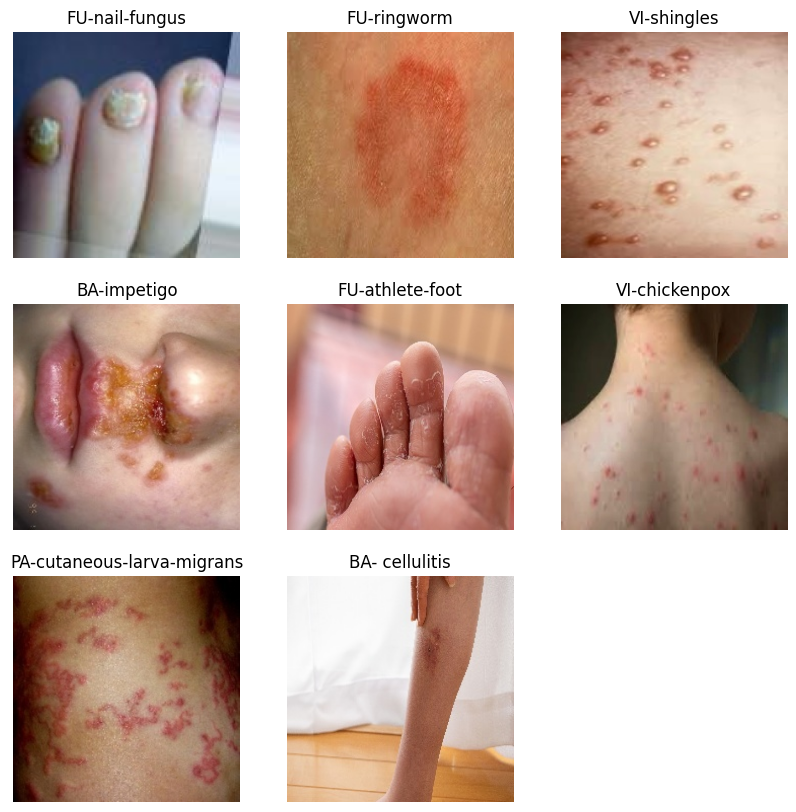

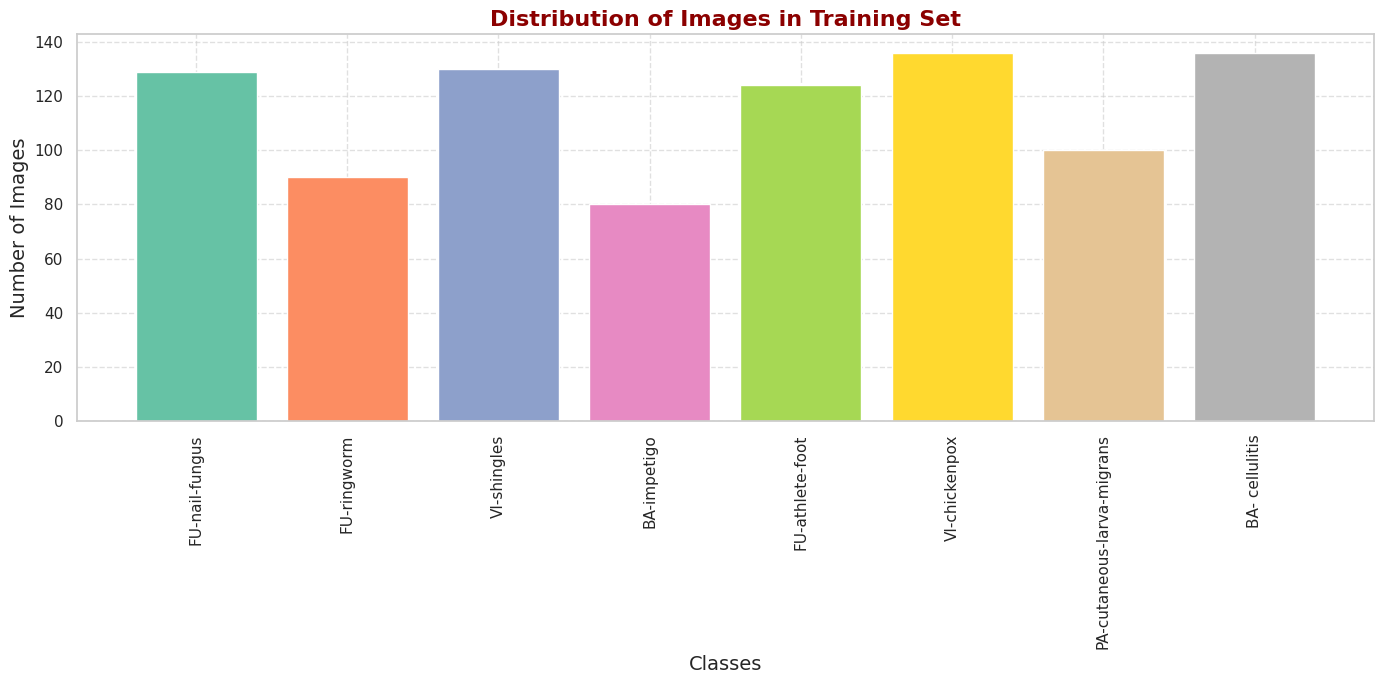

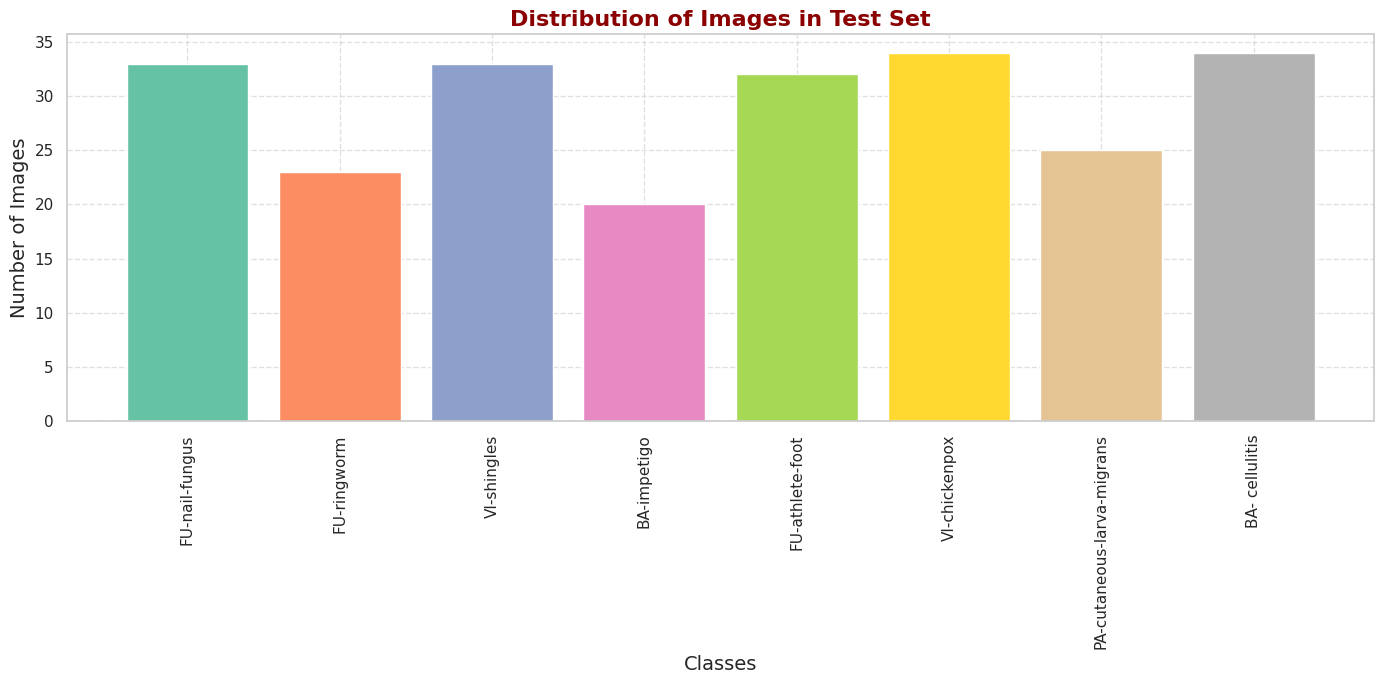

In [3]:

# Define dataset directories
train_set_url = '/kaggle/input/skin-disease-dataset/skin-disease-datasaet/train_set'
test_set_url = '/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set'

# List the contents of the directories
train_set = os.listdir(train_set_url)
test_set = os.listdir(test_set_url)

# Display the number of images in each category of the train and test sets
train_set_count = sum([len(os.listdir(os.path.join(train_set_url, folder))) for folder in train_set])
test_set_count = sum([len(os.listdir(os.path.join(test_set_url, folder))) for folder in test_set])

print(f"Number of images in training set: {train_set_count}")
print(f"Number of images in test set: {test_set_count}\n")

print("\nTrain Set Image Classification:")

# Print number of images per class in the training set
for class_name in train_set:
    class_path = os.path.join(train_set_url, class_name)
    num_images = len(os.listdir(class_path))
    print(f"Class '{class_name}' contains {num_images} images")

print("\nTest Set Image Classification:")

# Print number of images per class in the test set
for class_name in test_set:
    class_path = os.path.join(test_set_url, class_name)
    num_images = len(os.listdir(class_path))
    print(f"Class '{class_name}' contains {num_images} images")


# Plot some images from the dataset
class_names = train_set  # Adjust this to your dataset's actual class names

plt.figure(figsize=(10, 10))
for i, class_name in enumerate(class_names[:9]):
    img_path = str(list(pathlib.Path(train_set_url).glob(class_name + '/*'))[0])
    img = PIL.Image.open(img_path)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")
plt.show()

# Set Seaborn style for better aesthetics
sns.set(style="whitegrid", palette="muted")

# Plot the distribution of images for each class in the train set
class_counts = [len(os.listdir(os.path.join(train_set_url, class_name))) for class_name in class_names]
plt.figure(figsize=(14, 7))
plt.bar(class_names, class_counts, color=sns.color_palette("Set2", len(class_names)))
plt.xticks(rotation=90, fontsize=11)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.title('Distribution of Images in Training Set', fontsize=16, fontweight='bold', color='darkred')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot the distribution of images for each class in the test set
test_class_names = test_set
test_class_counts = [len(os.listdir(os.path.join(test_set_url, class_name))) for class_name in test_class_names]
plt.figure(figsize=(14, 7))
plt.bar(test_class_names, test_class_counts, color=sns.color_palette("Set2", len(test_class_names)))
plt.xticks(rotation=90, fontsize=11)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.title('Distribution of Images in Test Set', fontsize=16, fontweight='bold', color='darkred')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [4]:
import os
import pathlib
import numpy as np
import PIL
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define dataset directories
train_set_url = '/kaggle/input/skin-disease-dataset/skin-disease-datasaet/train_set'
augmented_dataset_dir = './augmented_train_dataset'  # Specify where augmented dataset will be stored

# Create the augmented dataset directory with class-wise subdirectories
if not os.path.exists(augmented_dataset_dir):
    os.makedirs(augmented_dataset_dir)

# Create subdirectories for each class
class_names = os.listdir(train_set_url)
for class_name in class_names:
    class_dir = os.path.join(augmented_dataset_dir, class_name)
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)

# Image data augmentation setup
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Augment images for each class
for class_name in class_names:
    class_path = os.path.join(train_set_url, class_name)
    augmented_class_path = os.path.join(augmented_dataset_dir, class_name)
    
    images = list(pathlib.Path(class_path).glob('*'))
    
    for img_path in images:
        img = PIL.Image.open(img_path)
        img = img.resize((150, 150))  # Resize to the target size
        img = np.array(img)
        img = img.reshape((1,) + img.shape)  # Reshape for augmentation
        
        # Generate and save augmented images
        prefix = f"aug_{os.path.splitext(os.path.basename(img_path))[0]}"
        augmented_images = datagen.flow(
            img, batch_size=1, save_to_dir=augmented_class_path, save_prefix=prefix, save_format='jpeg'
        )
        
        # Generate 5 augmented images per original image
        for i in range(5):
            next(augmented_images)  # Saving happens automatically due to save_to_dir

# Print the number of images in each class in the augmented dataset
print("\nNumber of images in each class after augmentation:")
for class_name in class_names:
    class_dir = os.path.join(augmented_dataset_dir, class_name)
    num_images = len(os.listdir(class_dir))
    print(f"Class '{class_name}' contains {num_images} images.")



Number of images in each class after augmentation:
Class 'FU-nail-fungus' contains 645 images.
Class 'FU-ringworm' contains 450 images.
Class 'VI-shingles' contains 650 images.
Class 'BA-impetigo' contains 400 images.
Class 'FU-athlete-foot' contains 620 images.
Class 'VI-chickenpox' contains 679 images.
Class 'PA-cutaneous-larva-migrans' contains 500 images.
Class 'BA- cellulitis' contains 680 images.


**Data Augmentation:** <br>

**For training data:**<br>
Applies transformations such as rotation, shifting, shearing, zooming, and flipping to augment the dataset and reduce overfitting.<br>
**For test data:**<br>
Only rescaling is applied since augmentation is not needed.<br>

**Normalization:**<br>
All images are scaled to have pixel values in the range [0, 1] for compatibility with deep learning models.<br>

**Image Generators:** <br>
**flow_from_directory:** Automatically labels images based on their folder structure and resizes them to 224x224, which is the input size for popular deep learning models like ResNet and DenseNet.<br>
**class_mode='categorical':** Suitable for multi-class classification.<br>


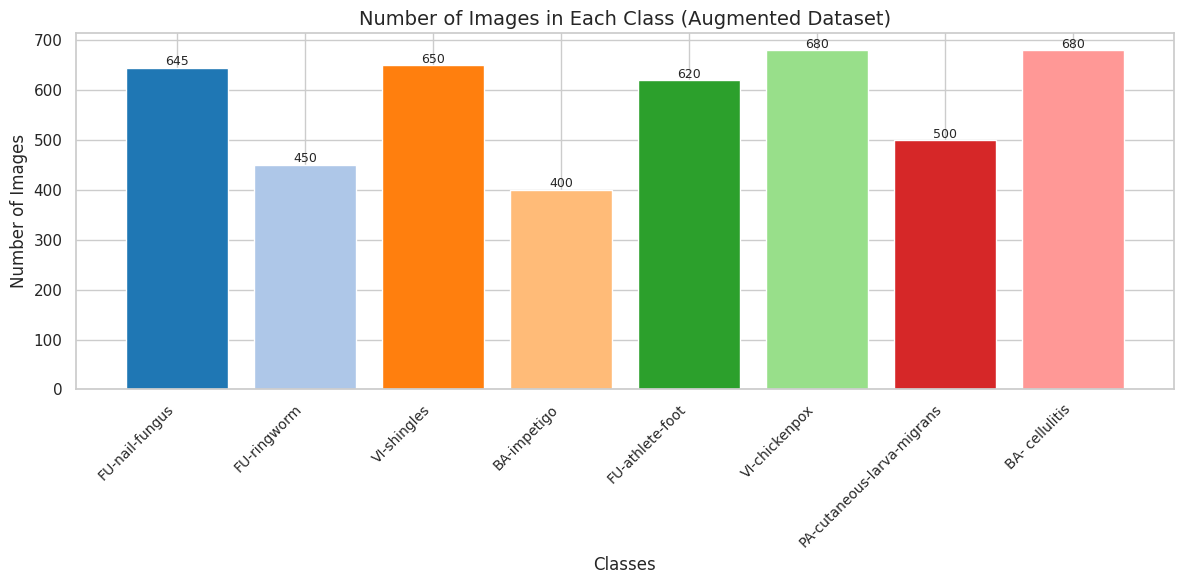

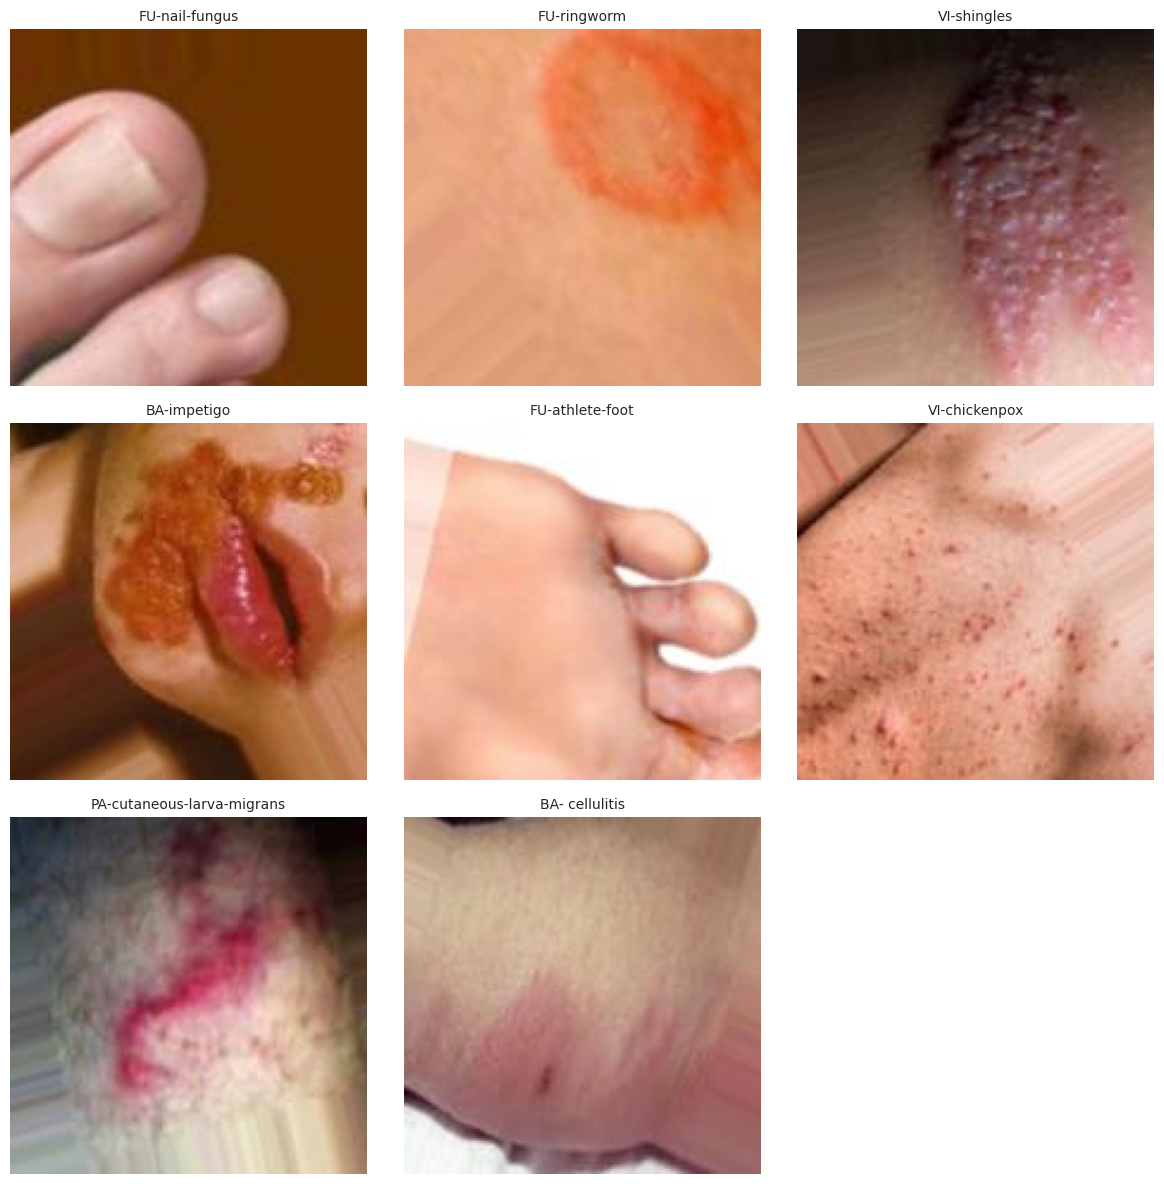

In [4]:
import matplotlib.pyplot as plt
import os
import random
from PIL import Image

# Plot the number of images in each class in the augmented dataset
class_counts = [len(os.listdir(os.path.join(augmented_dataset_dir, class_name))) for class_name in class_names]

plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, class_counts, color=plt.cm.tab20.colors[:len(class_names)])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Number of Images in Each Class (Augmented Dataset)', fontsize=14)
for bar, count in zip(bars, class_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, str(count), ha='center', fontsize=9)
plt.tight_layout()
plt.show()

# Display sample augmented images
plt.figure(figsize=(12, 12))
for i, class_name in enumerate(class_names[:9]):  # Display samples for up to 9 classes
    class_dir = os.path.join(augmented_dataset_dir, class_name)
    sample_image = random.choice(os.listdir(class_dir))
    img_path = os.path.join(class_dir, sample_image)
    img = Image.open(img_path)
    
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(class_name, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


**Base Model:**<br>
Uses a pre-trained model (e.g., MobileNetV2, DenseNet121) without its top layers (include_top=False).
Layers are frozen to retain the pre-trained weights, which provide a strong starting point.<br>

**Custom Layers:**<br>
**GlobalAveragePooling2D:** Reduces the spatial dimensions of feature maps to a single vector, aggregating important features. <br>
**Dense (1024 neurons):** Adds a fully connected layer with ReLU activation to capture complex patterns.<br>
**Dropout (0.5):** Regularizes the model to prevent overfitting.<br>
**Output Layer:** The number of neurons equals the number of classes, with softmax activation for multi-class classification.<br>

**Compilation:**<br>
**Adam Optimizer:** Adaptive learning rate optimization.
**Sparse Categorical Crossentropy: **Appropriate for sparse integer labels.<br>
**Accuracy Metric:** Tracks classification performance.

Found 4625 images belonging to 8 classes.
Found 233 images belonging to 8 classes.
Training MobileNetV2...
Epoch 1/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.5934 - loss: 1.3701 - val_accuracy: 0.7897 - val_loss: 0.6215
Epoch 2/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8860 - loss: 0.3454 - val_accuracy: 0.8155 - val_loss: 0.6707
Epoch 3/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9124 - loss: 0.2514 - val_accuracy: 0.8412 - val_loss: 0.5301
Epoch 4/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9417 - loss: 0.1780 - val_accuracy: 0.8798 - val_loss: 0.4341
Epoch 5/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9514 - loss: 0.1365 - val_accuracy: 0.8498 - val_loss: 0.5918
Epoch 6/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.9613 - loss: 0.1155 - val_accuracy: 0.8798 - val_loss: 0.4321
Epoch 7/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.9775 - loss: 0.0788 - val_accuracy: 0.8798 - val_lo

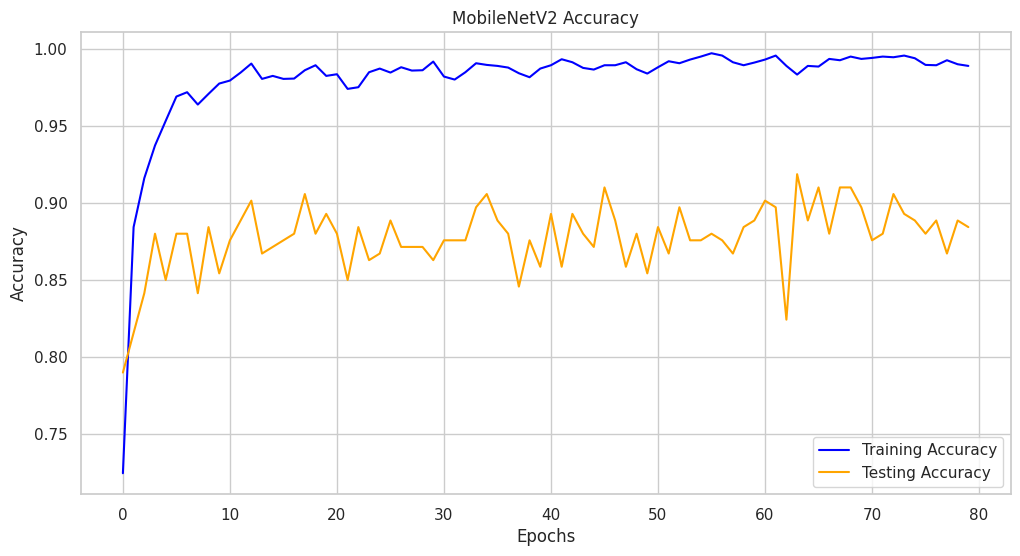

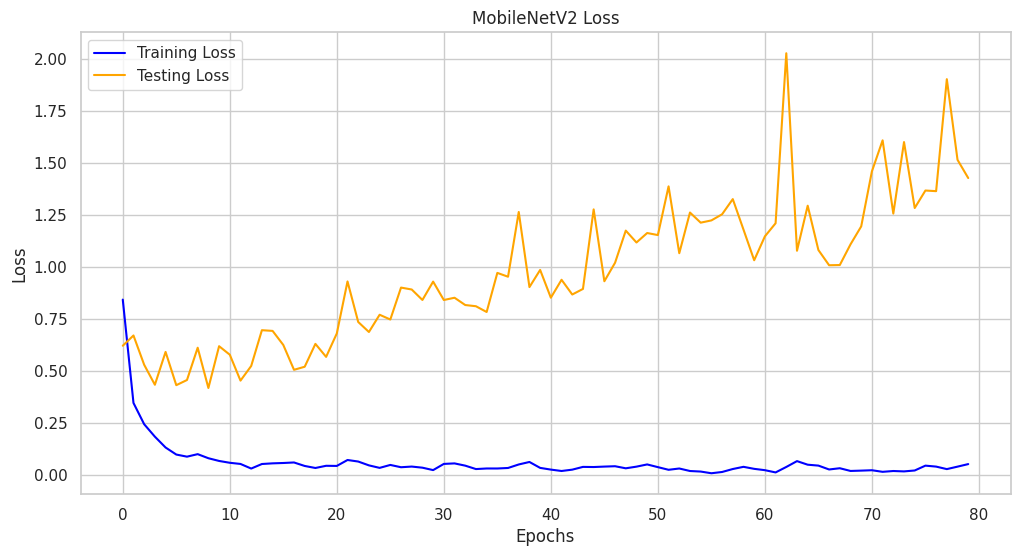

Training DenseNet121...
Epoch 1/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 46s 192ms/step - accuracy: 0.6250 - loss: 1.1103 - val_accuracy: 0.8627 - val_loss: 0.3671
Epoch 2/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.8891 - loss: 0.3243 - val_accuracy: 0.8884 - val_loss: 0.2894
Epoch 3/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.9229 - loss: 0.2065 - val_accuracy: 0.9313 - val_loss: 0.2360
Epoch 4/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.9523 - loss: 0.1549 - val_accuracy: 0.9142 - val_loss: 0.1987
Epoch 5/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.9498 - loss: 0.1383 - val_accuracy: 0.9185 - val_loss: 0.2544
Epoch 6/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.9734 - loss: 0.0862 - val_accuracy: 0.9313 - val_loss: 0.2079
Epoch 7/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.9813 - loss: 0.0635 - val_accuracy: 0.9356 - val_loss: 0.1708
Epoch 8/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy:

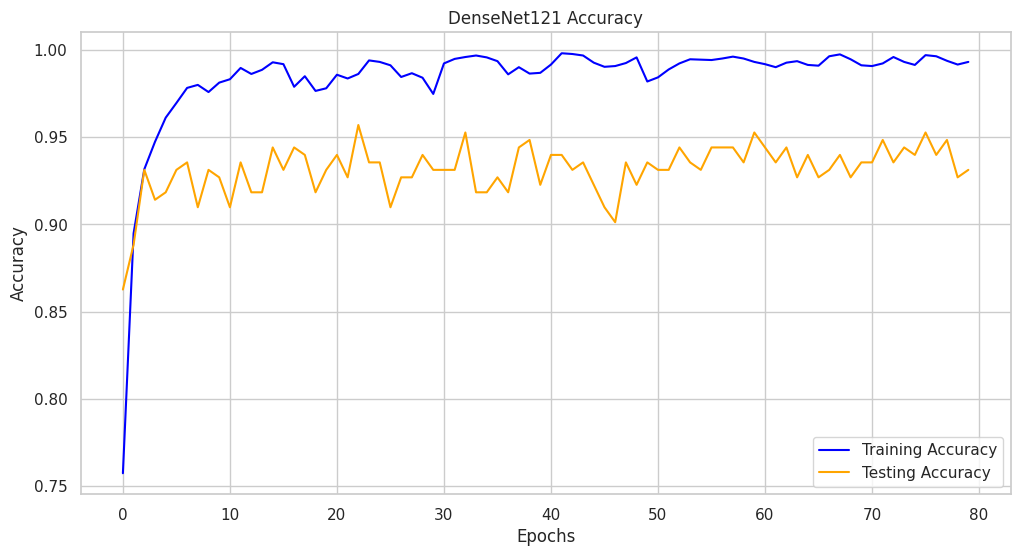

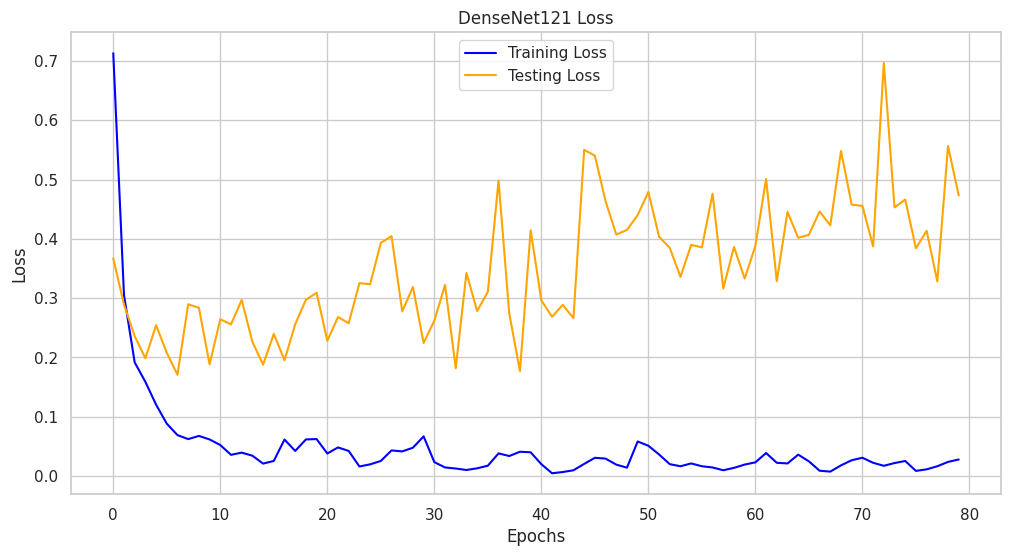

Training VGG16...
Epoch 1/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 65s 319ms/step - accuracy: 0.3592 - loss: 1.7335 - val_accuracy: 0.7082 - val_loss: 0.9021
Epoch 2/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 24s 162ms/step - accuracy: 0.6372 - loss: 1.0433 - val_accuracy: 0.7639 - val_loss: 0.7575
Epoch 3/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 24s 161ms/step - accuracy: 0.6907 - loss: 0.8406 - val_accuracy: 0.7511 - val_loss: 0.8136
Epoch 4/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 24s 163ms/step - accuracy: 0.7390 - loss: 0.7394 - val_accuracy: 0.7897 - val_loss: 0.6055
Epoch 5/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 24s 163ms/step - accuracy: 0.7593 - loss: 0.6747 - val_accuracy: 0.8197 - val_loss: 0.5529
Epoch 6/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 24s 163ms/step - accuracy: 0.7900 - loss: 0.5964 - val_accuracy: 0.7897 - val_loss: 0.5799
Epoch 7/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 24s 164ms/step - accuracy: 0.7950 - loss: 0.5838 - val_accuracy: 0.8369 - val_loss: 0.5492
Epoch 8/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 24s 164ms/step - accuracy

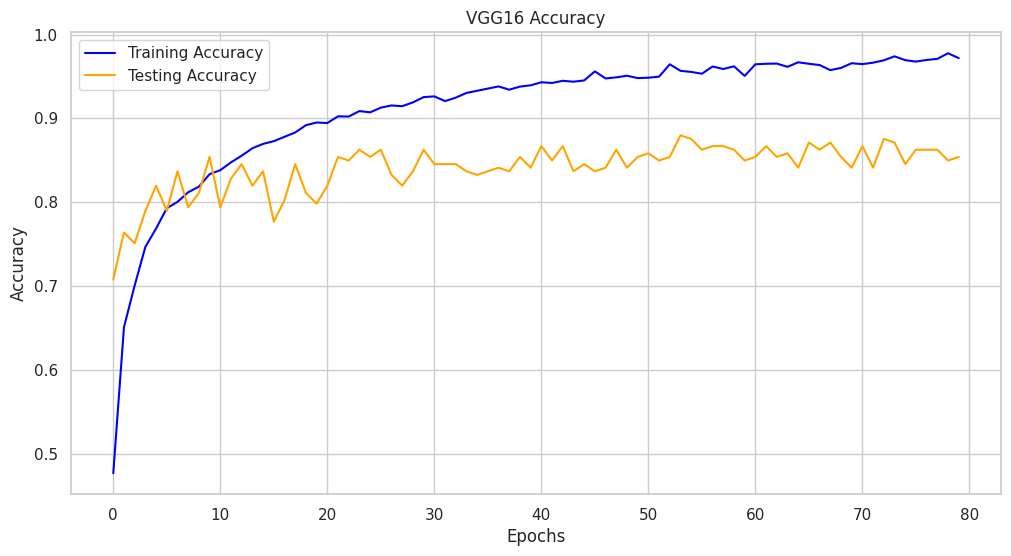

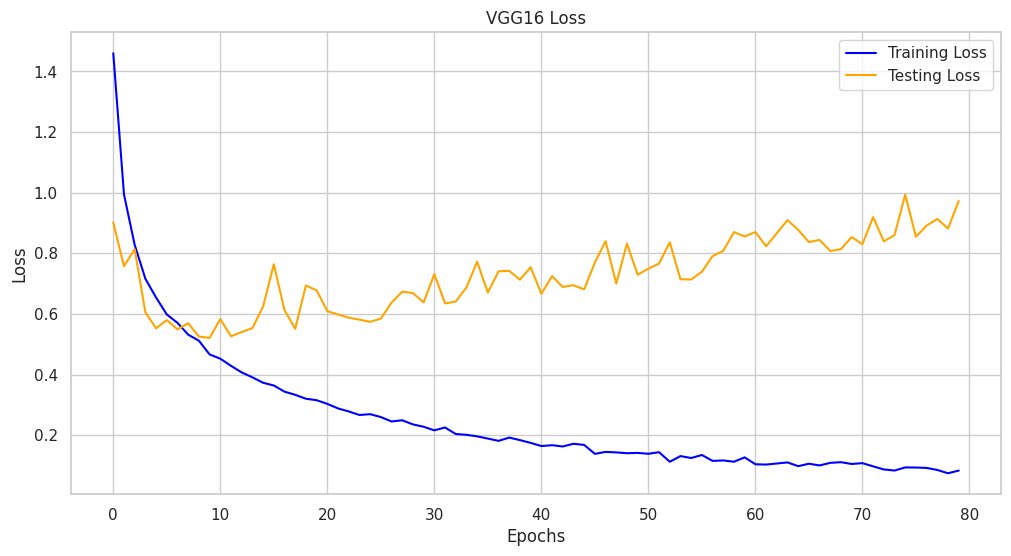

Training InceptionV3...
Epoch 1/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 45s 198ms/step - accuracy: 0.5582 - loss: 1.4830 - val_accuracy: 0.8627 - val_loss: 0.4819
Epoch 2/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.8428 - loss: 0.4572 - val_accuracy: 0.8712 - val_loss: 0.4348
Epoch 3/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.8995 - loss: 0.3192 - val_accuracy: 0.8927 - val_loss: 0.3909
Epoch 4/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9121 - loss: 0.2523 - val_accuracy: 0.8841 - val_loss: 0.3802
Epoch 5/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9361 - loss: 0.1891 - val_accuracy: 0.8927 - val_loss: 0.4037
Epoch 6/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9380 - loss: 0.1767 - val_accuracy: 0.9013 - val_loss: 0.3928
Epoch 7/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.9470 - loss: 0.1477 - val_accuracy: 0.9142 - val_loss: 0.3732
Epoch 8/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy:

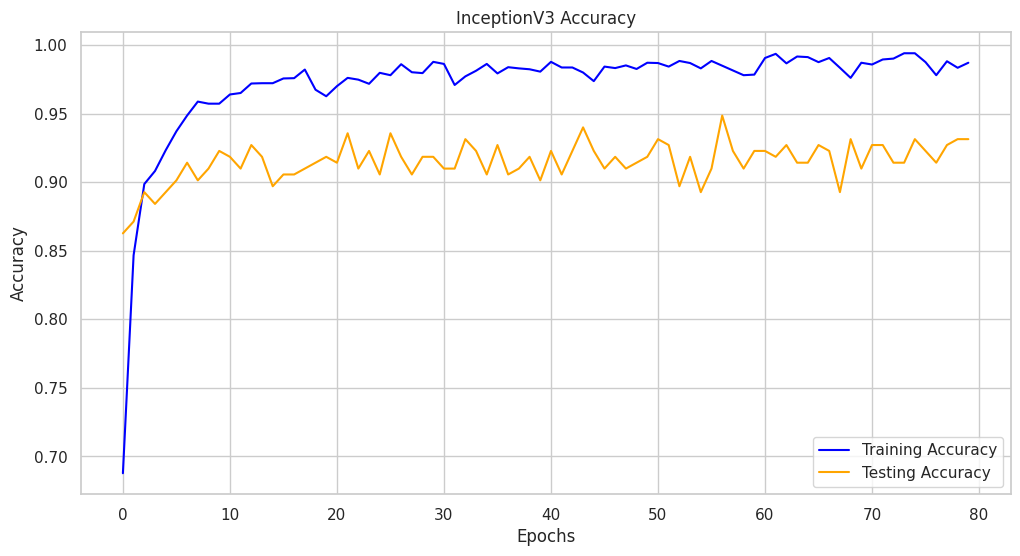

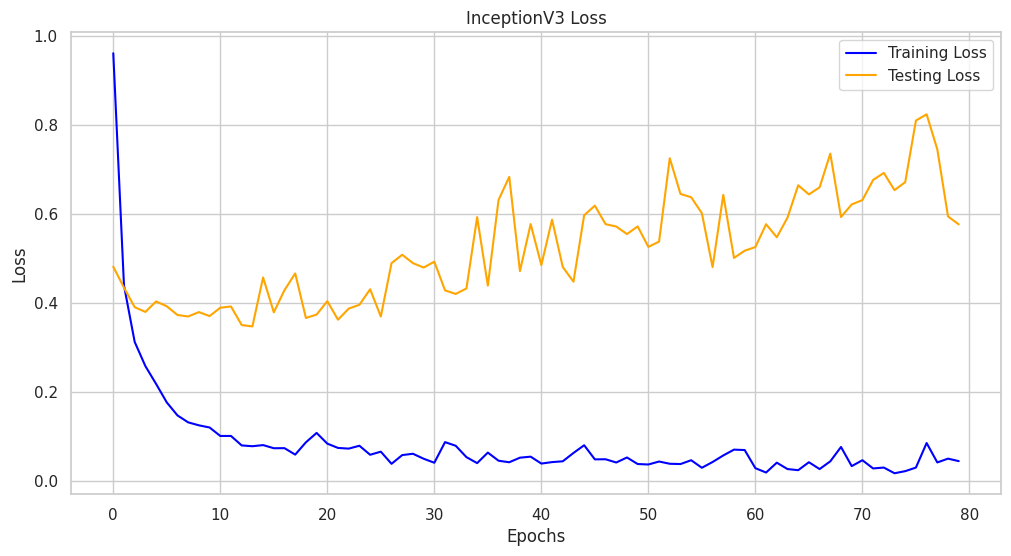

ValueError: The layer sequential_12 has never been called and thus has no defined input.

In [9]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2, DenseNet121, VGG16, InceptionV3

# Paths to the augmented datasets
augmented_train_dataset = '/kaggle/working/augmented_train_dataset'
test_dataset = '/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set'

# Image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 32

# Data generators for augmented train and test datasets
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    augmented_train_dataset,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
)

test_generator = test_datagen.flow_from_directory(
    test_dataset,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
)

# Define function to create a model using a pre-trained base
def create_model(base_model, img_height, img_width, num_classes):
    # Freeze pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Custom layers on top of pre-trained base
    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Number of classes
num_classes = len(train_generator.class_indices)

# Define base models
mobile_net_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Create models
mobile_net_model = create_model(mobile_net_base, img_height, img_width, num_classes)
densenet_model = create_model(densenet_base, img_height, img_width, num_classes)
vgg16_model = create_model(vgg16_base, img_height, img_width, num_classes)
inception_model = create_model(inception_base, img_height, img_width, num_classes)

# Train models and plot learning curves
def train_and_plot(model, train_gen, test_gen, model_name, epochs=80):
    print(f"Training {model_name}...")
    history = model.fit(train_gen, epochs=epochs, validation_data=test_gen)
    print(f"{model_name} Training Complete.\n")
    
    # Plot learning curves
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Testing Accuracy', color='orange')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Testing Loss', color='orange')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    return history

mobile_net_history = train_and_plot(mobile_net_model, train_generator, test_generator, "MobileNetV2")
densenet_history = train_and_plot(densenet_model, train_generator, test_generator, "DenseNet121")
vgg16_history = train_and_plot(vgg16_model, train_generator, test_generator, "VGG16")
inception_history = train_and_plot(inception_model, train_generator, test_generator, "InceptionV3")

# # Generate and display feature maps
# def plot_feature_maps(model, test_img_path):
#     img = tf.keras.preprocessing.image.load_img(test_img_path, target_size=(img_height, img_width))
#     img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
#     img_array = tf.expand_dims(img_array, axis=0)
    
#     feature_model = Model(inputs=model.input, outputs=[layer.output for layer in model.layers if 'conv' in layer.name or 'pool' in layer.name])
#     feature_maps = feature_model.predict(img_array)
    
#     for idx, fmap in enumerate(feature_maps):
#         print(f"Feature map {idx+1} shape: {fmap.shape}")
#         fmap_grid = fmap[0, :, :, :min(fmap.shape[-1], 16)]  # Display up to 16 feature maps
#         plt.figure(figsize=(15, 15))
#         for i in range(fmap_grid.shape[-1]):
#             ax = plt.subplot(4, 4, i + 1)
#             plt.imshow(fmap_grid[:, :, i], cmap='viridis')
#             plt.axis('off')
#         plt.show()

# Example: Generate feature maps for an image from the test dataset
# sample_img_path = '/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set/VI-shingles/127_VI-shingles (32).jpg'
# plot_feature_maps(mobile_net_model, sample_img_path)
# plot_feature_maps(densenet_model, sample_img_path)
# plot_feature_maps(vgg16_model, sample_img_path)
# plot_feature_maps(inception_model, sample_img_path)


In [10]:
# Print final accuracies of each model
def print_final_accuracies(history, model_name):
    print(f"Final Training Accuracy for {model_name}: {history.history['accuracy'][-1]:.4f}")
    print(f"Final Testing Accuracy for {model_name}: {history.history['val_accuracy'][-1]:.4f}\n")

# Print the accuracies for each model
print_final_accuracies(mobile_net_history, 'MobileNetV2')
print_final_accuracies(densenet_history, 'DenseNet121')
print_final_accuracies(vgg16_history, 'VGG16')
print_final_accuracies(inception_history, 'InceptionV3')


Final Training Accuracy for MobileNetV2: 0.9888
Final Testing Accuracy for MobileNetV2: 0.8841

Final Training Accuracy for DenseNet121: 0.9933
Final Testing Accuracy for DenseNet121: 0.9313

Final Training Accuracy for VGG16: 0.9719
Final Testing Accuracy for VGG16: 0.8541

Final Training Accuracy for InceptionV3: 0.9870
Final Testing Accuracy for InceptionV3: 0.9313



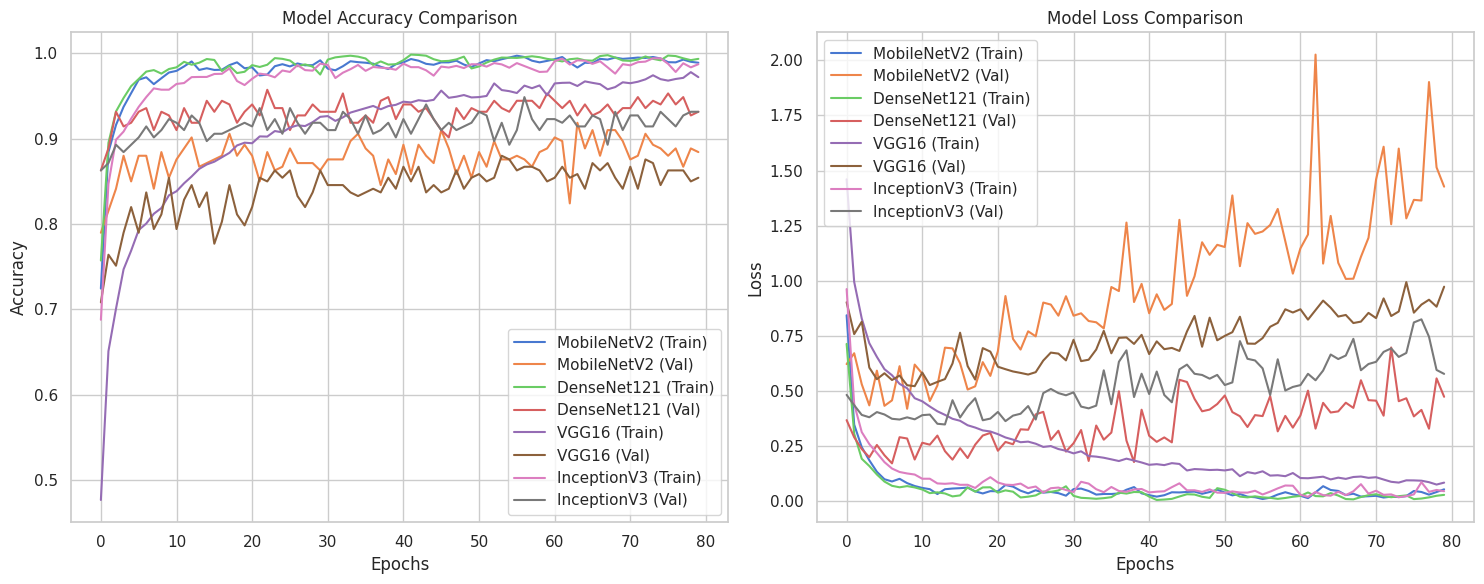

In [21]:
import matplotlib.pyplot as plt

# Function to plot comparison graphs of the models
def plot_comparison_graphs(histories, model_names):
    plt.figure(figsize=(15, 6))

    # Plotting training and validation accuracies
    plt.subplot(1, 2, 1)
    for history, model_name in zip(histories, model_names):
        plt.plot(history.history['accuracy'], label=f'{model_name} (Train)')
        plt.plot(history.history['val_accuracy'], label=f'{model_name} (Val)')
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting training and validation losses
    plt.subplot(1, 2, 2)
    for history, model_name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{model_name} (Train)')
        plt.plot(history.history['val_loss'], label=f'{model_name} (Val)')
    plt.title('Model Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Define your models and histories
histories = [mobile_net_history, densenet_history, vgg16_history, inception_history]
model_names = ['MobileNetV2', 'DenseNet121', 'VGG16', 'InceptionV3']

# Plot comparison graphs for the models
plot_comparison_graphs(histories, model_names)


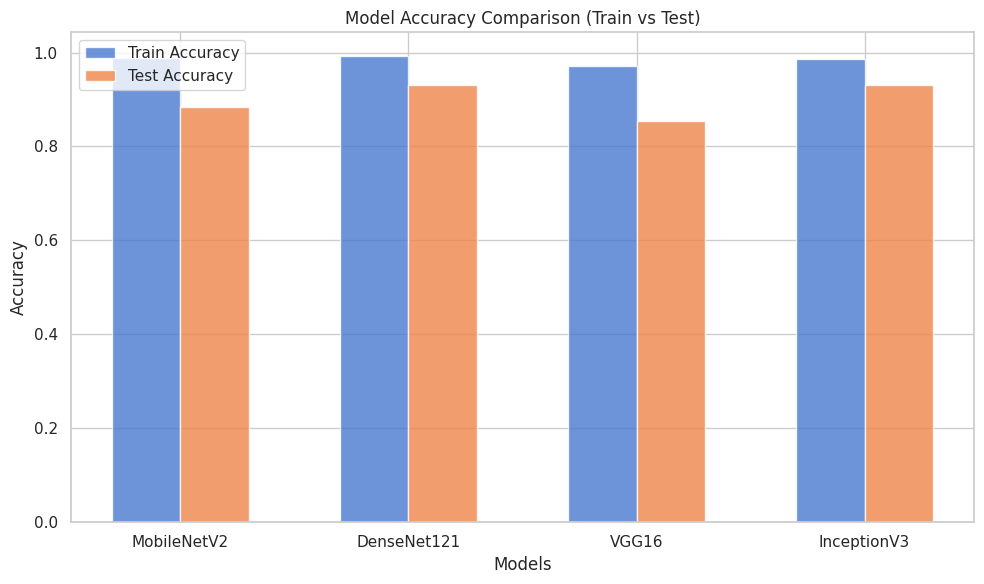

In [22]:
import matplotlib.pyplot as plt

# Function to extract final accuracies from histories
def get_final_accuracies(histories, model_names):
    train_accuracies = []
    test_accuracies = []  # Changed from val_accuracies to test_accuracies
    for history in histories:
        train_accuracies.append(history.history['accuracy'][-1])
        test_accuracies.append(history.history['val_accuracy'][-1])  # Keep using val_accuracy for testing
    return train_accuracies, test_accuracies

# Get final accuracies for each model
train_accuracies, test_accuracies = get_final_accuracies([mobile_net_history, densenet_history, vgg16_history, inception_history], ['MobileNetV2', 'DenseNet121', 'VGG16', 'InceptionV3'])

# Bar chart for final accuracies
def plot_final_accuracy_bar_chart(train_accuracies, test_accuracies, model_names):
    x = range(len(model_names))  # x-axis labels (model names)

    # Create a bar chart for training and testing accuracies
    plt.figure(figsize=(10, 6))
    bar_width = 0.3  # width of the bars
    opacity = 0.8
    plt.bar(x, train_accuracies, bar_width, alpha=opacity, label='Train Accuracy')
    plt.bar([i + bar_width for i in x], test_accuracies, bar_width, alpha=opacity, label='Test Accuracy')

    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Comparison (Train vs Test)')
    plt.xticks([i + bar_width / 2 for i in x], model_names)  # x-axis labels are shifted to fit both bars
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the final accuracy comparison bar chart
plot_final_accuracy_bar_chart(train_accuracies, test_accuracies, ['MobileNetV2', 'DenseNet121', 'VGG16', 'InceptionV3'])


**Input Image Loading and Preprocessing:** <br>

A test image is loaded using tf.keras.preprocessing.image.load_img and resized to the model's input dimensions (img_height, img_width).<br>
The image is then normalized by dividing pixel values by 255 and expanded into a batch of size 1 (tf.expand_dims).<br>

**Base Model Extraction:** <br>
The base model (e.g., DenseNet121, InceptionV3) is extracted from the Sequential model. The assumption is that the first layer in the Sequential model is the pre-trained base.<br>

**Layer Selection for Visualization:** <br>
The script selects the first n and last n layers of the base model for feature extraction (layers_to_visualize controls this).<br>
From the selected layers, only convolutional ('conv') or pooling layers ('pool') are retained for feature map generation. These layers are where most meaningful spatial features are extracted.<br>

**Feature Extraction Submodel:** <br>
A new model (feature_model) is created using the selected layers of the base model. The submodel outputs feature maps from these layers.

**Feature Map Generation:** <br>
The test image is passed through the feature_model to generate feature maps for the selected layers.<br>
Each feature map is a tensor of dimensions (height, width, channels), representing the spatial features extracted at a specific layer.<br>

**Visualization of Feature Maps:** <br>
For each feature map, a grid of images is created, where each image represents one of the first max_feature_maps channels.<br>
Matplotlib (plt) is used to display the feature maps with the viridis colormap.
The script adjusts grid size dynamically (rows and cols) based on the number of channels to ensure a clean layout.<br>

Generating feature maps for DenseNet121...
Loading and preprocessing the test image...
Image shape after preprocessing: (1, 224, 224, 3)
Base model: densenet121
Total layers in the base model: 427
Selecting the first 5 layers and the last 5 layers...
Creating submodel for feature extraction...
Submodel created with 425 layers for feature extraction.
Generating feature maps...
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Generated 6 feature maps from the selected layers.
Plotting feature map 1 with shape: (1, 112, 112, 64)


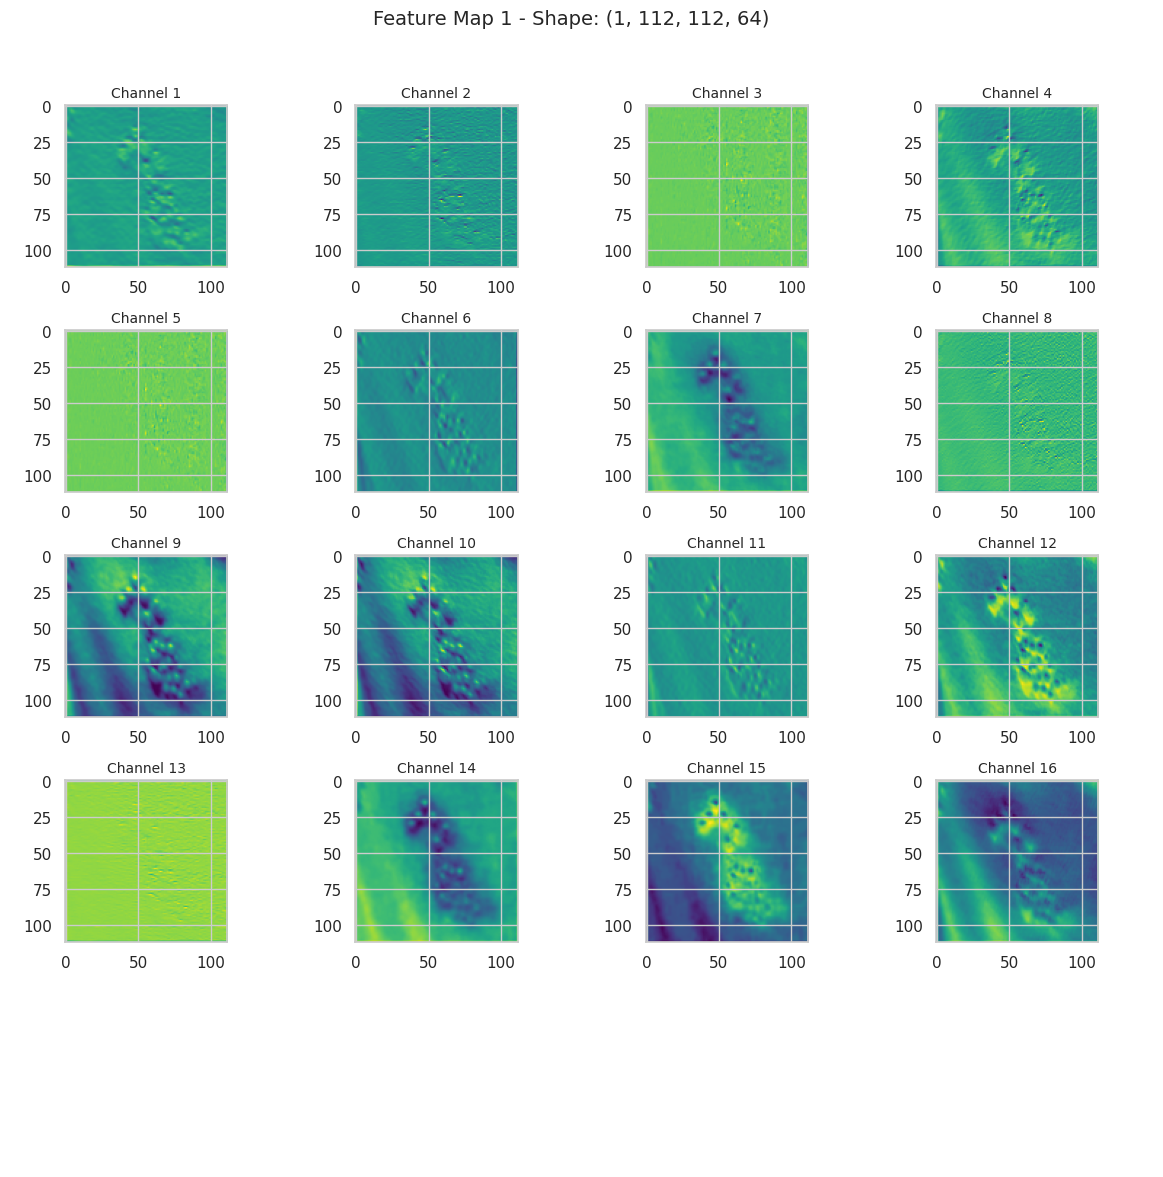

Plotting feature map 2 with shape: (1, 112, 112, 64)


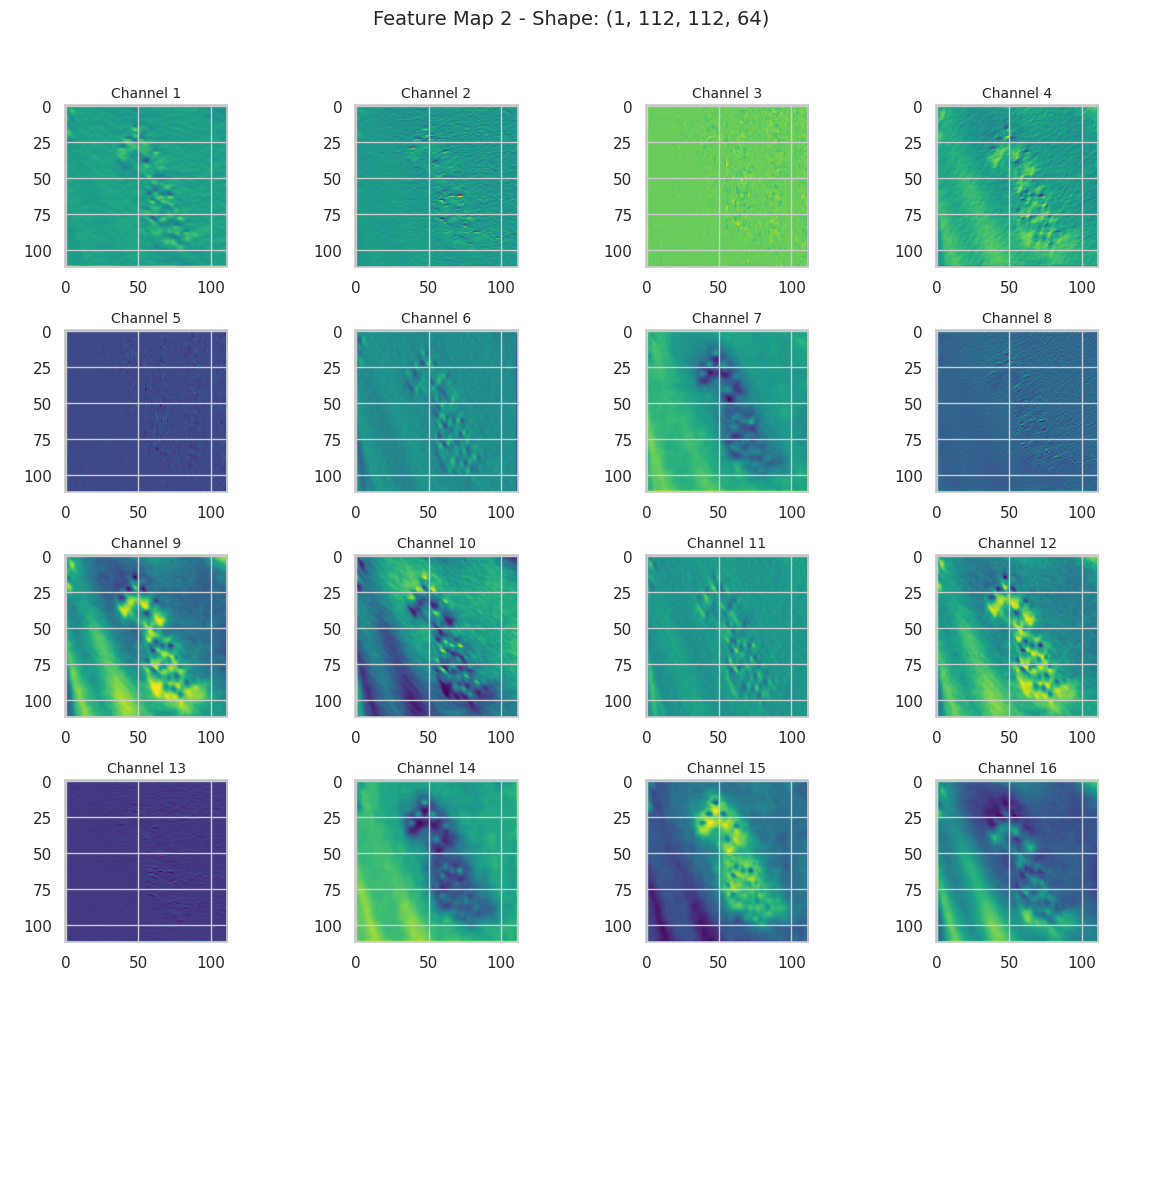

Plotting feature map 3 with shape: (1, 112, 112, 64)


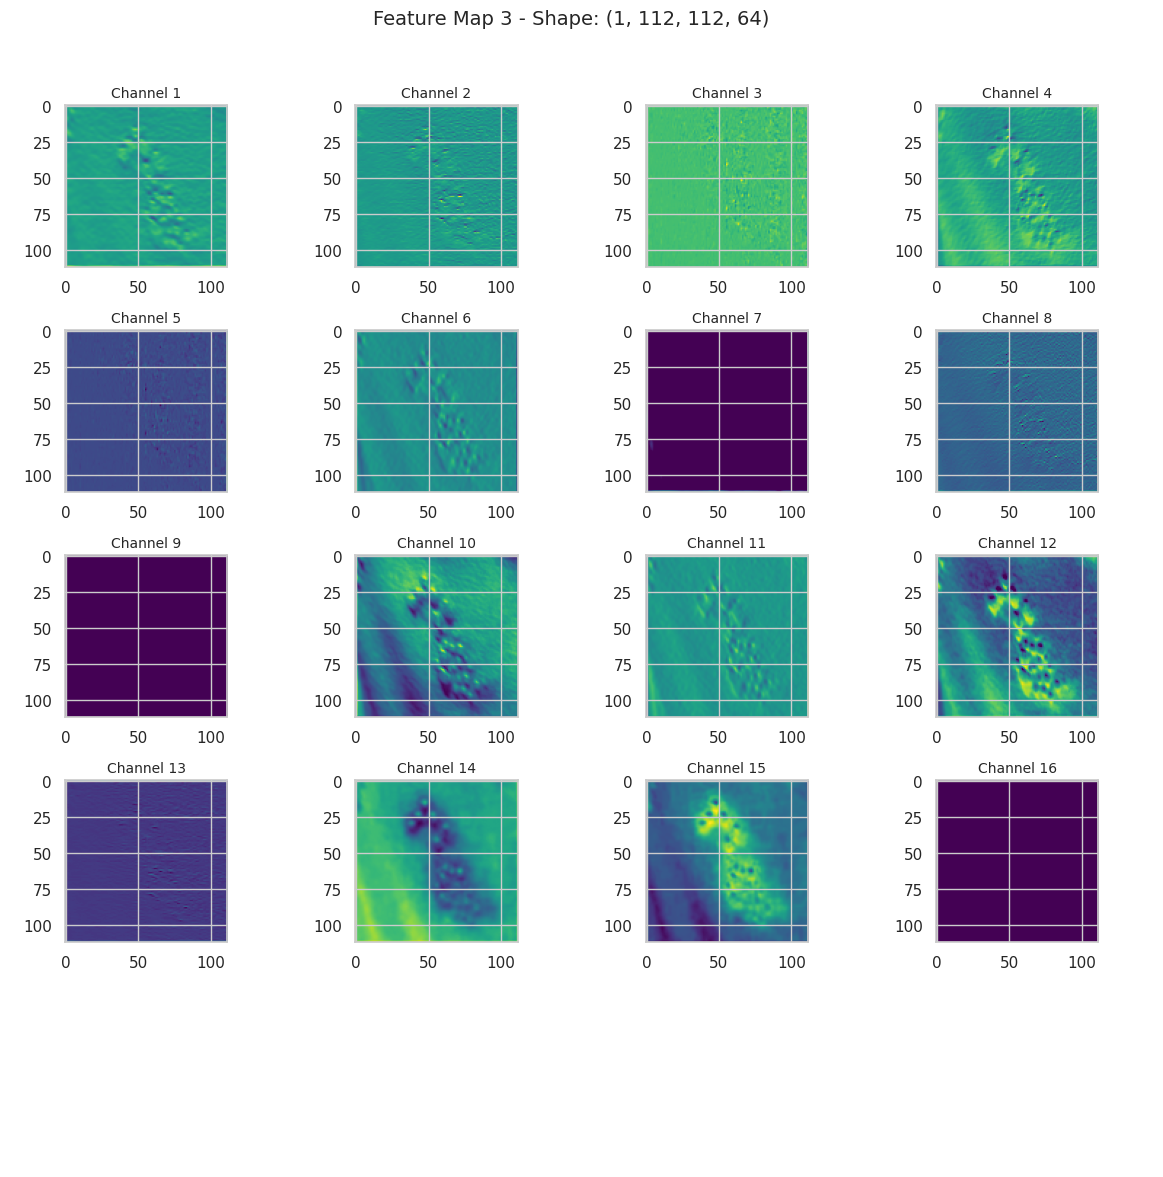

Plotting feature map 4 with shape: (1, 7, 7, 128)


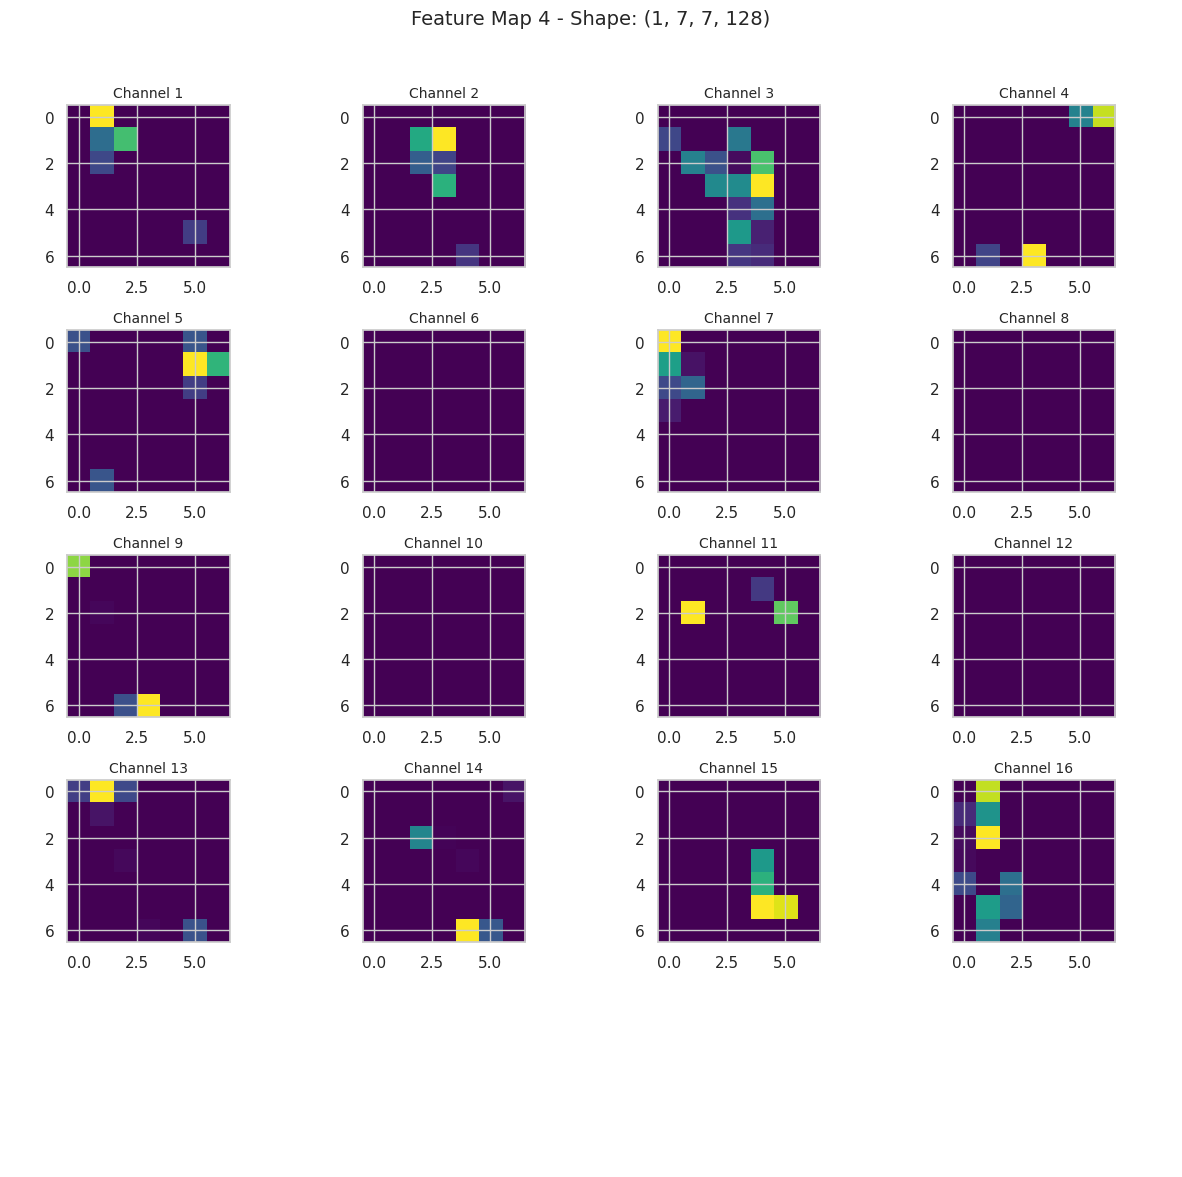

Plotting feature map 5 with shape: (1, 7, 7, 32)


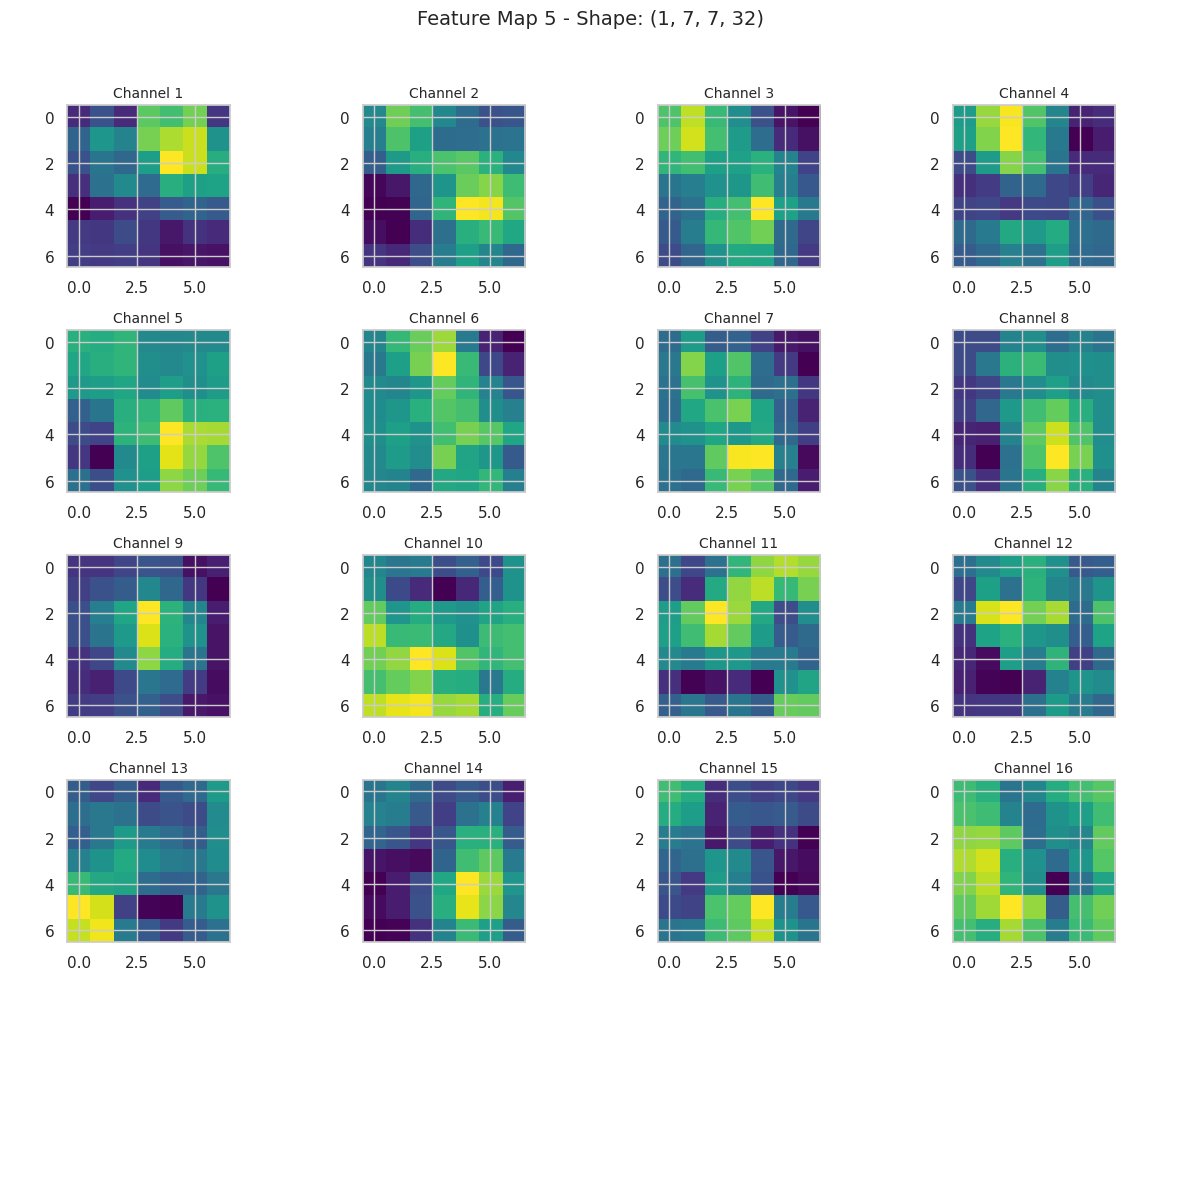

Plotting feature map 6 with shape: (1, 7, 7, 1024)


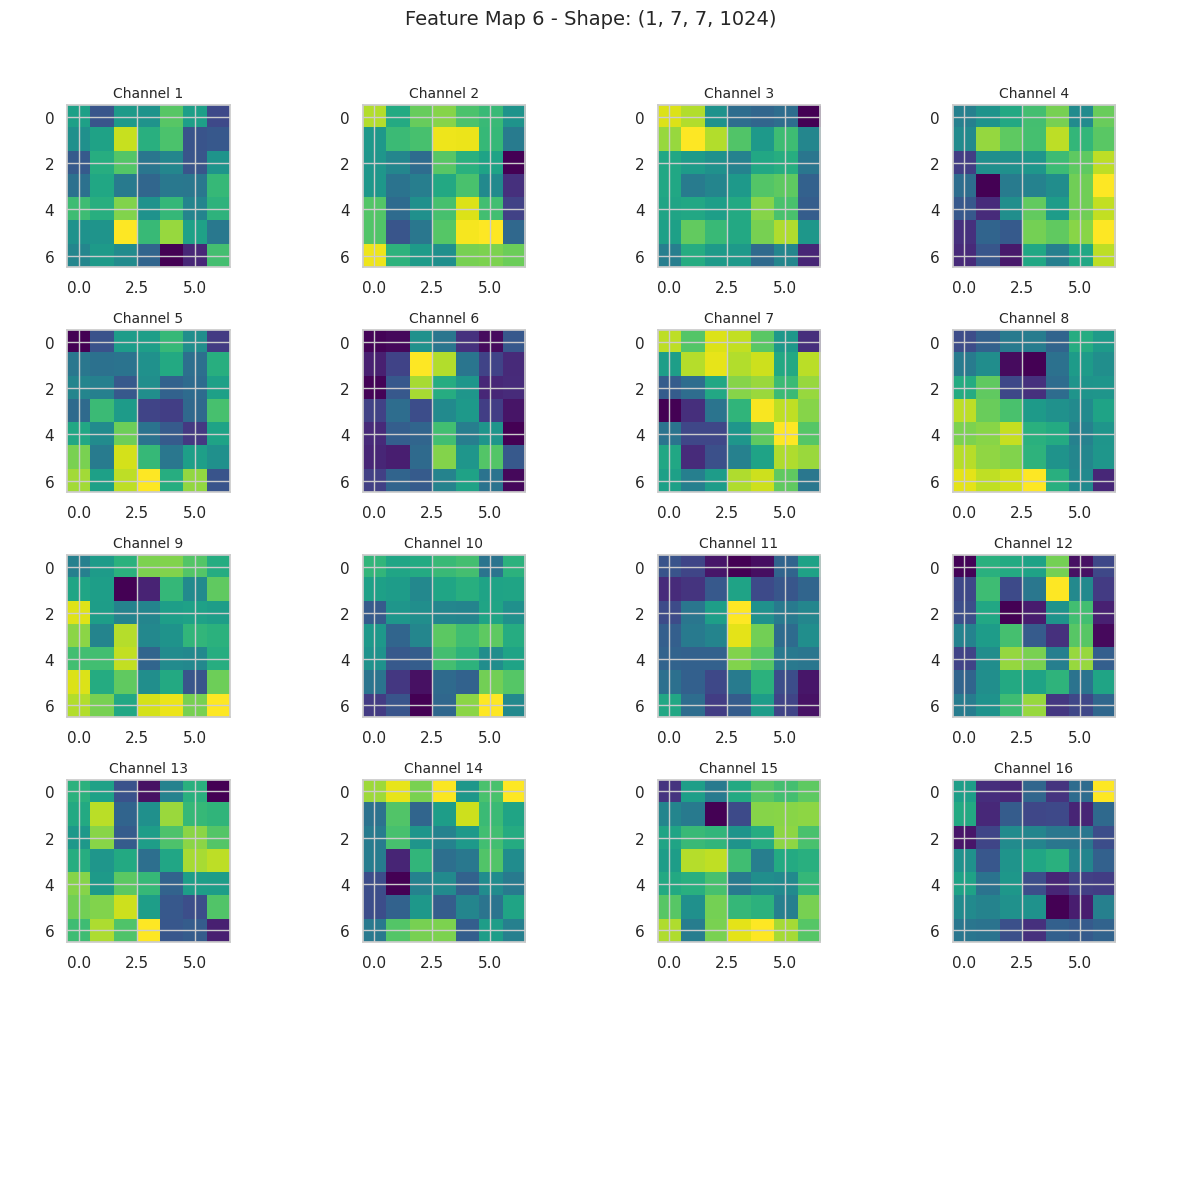

Generating feature maps for InceptionV3...
Loading and preprocessing the test image...
Image shape after preprocessing: (1, 224, 224, 3)
Base model: inception_v3
Total layers in the base model: 311
Selecting the first 5 layers and the last 5 layers...
Creating submodel for feature extraction...
Submodel created with 5 layers for feature extraction.
Generating feature maps...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Generated 2 feature maps from the selected layers.
Plotting feature map 1 with shape: (1, 111, 111, 32)


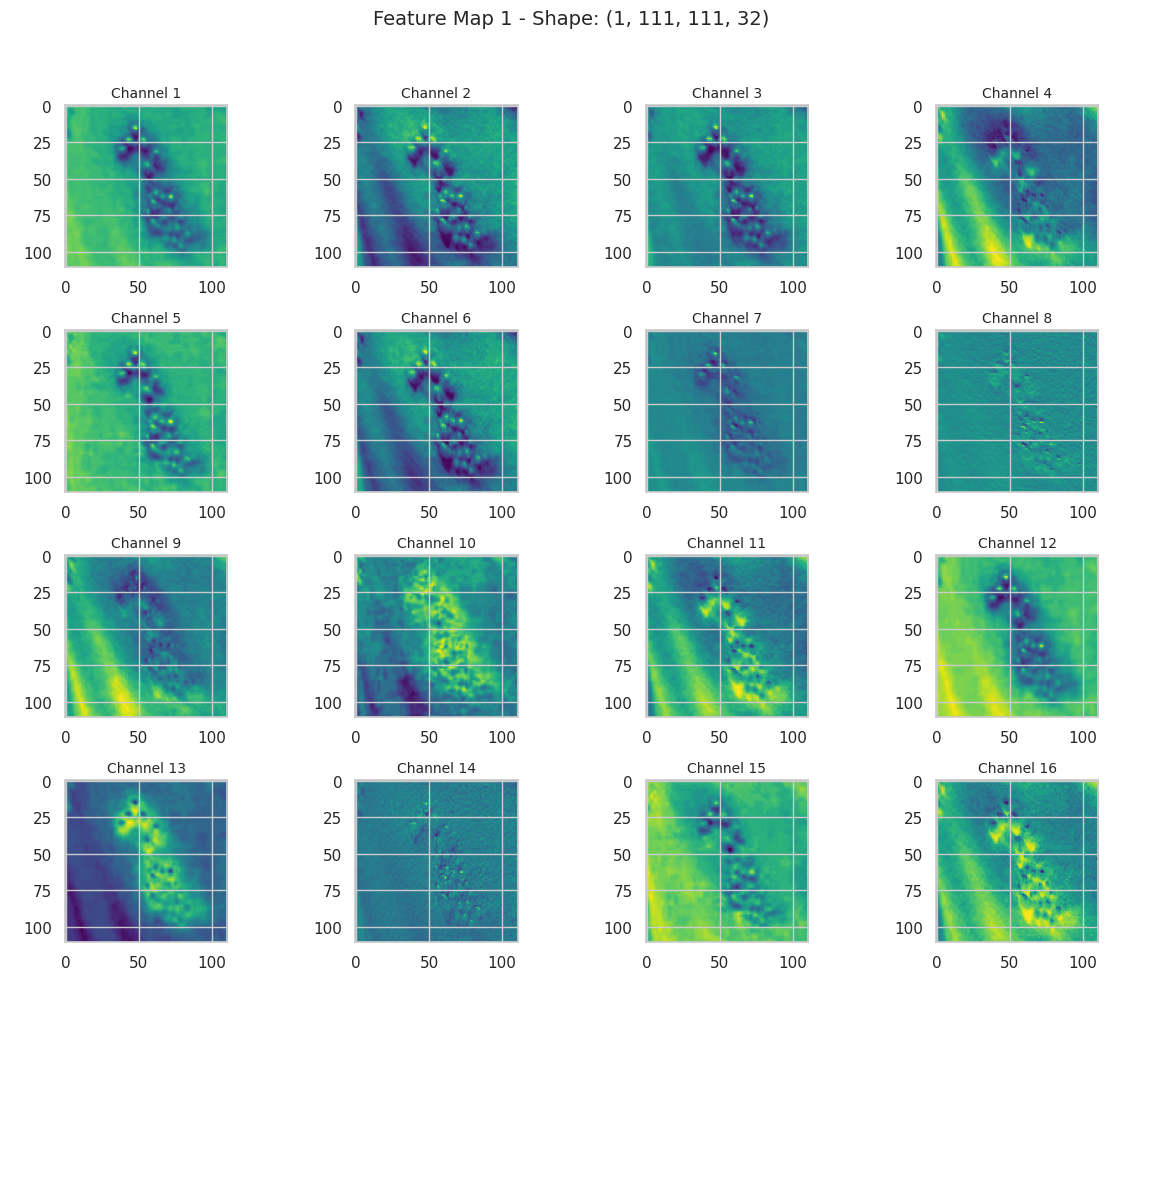

Plotting feature map 2 with shape: (1, 109, 109, 32)


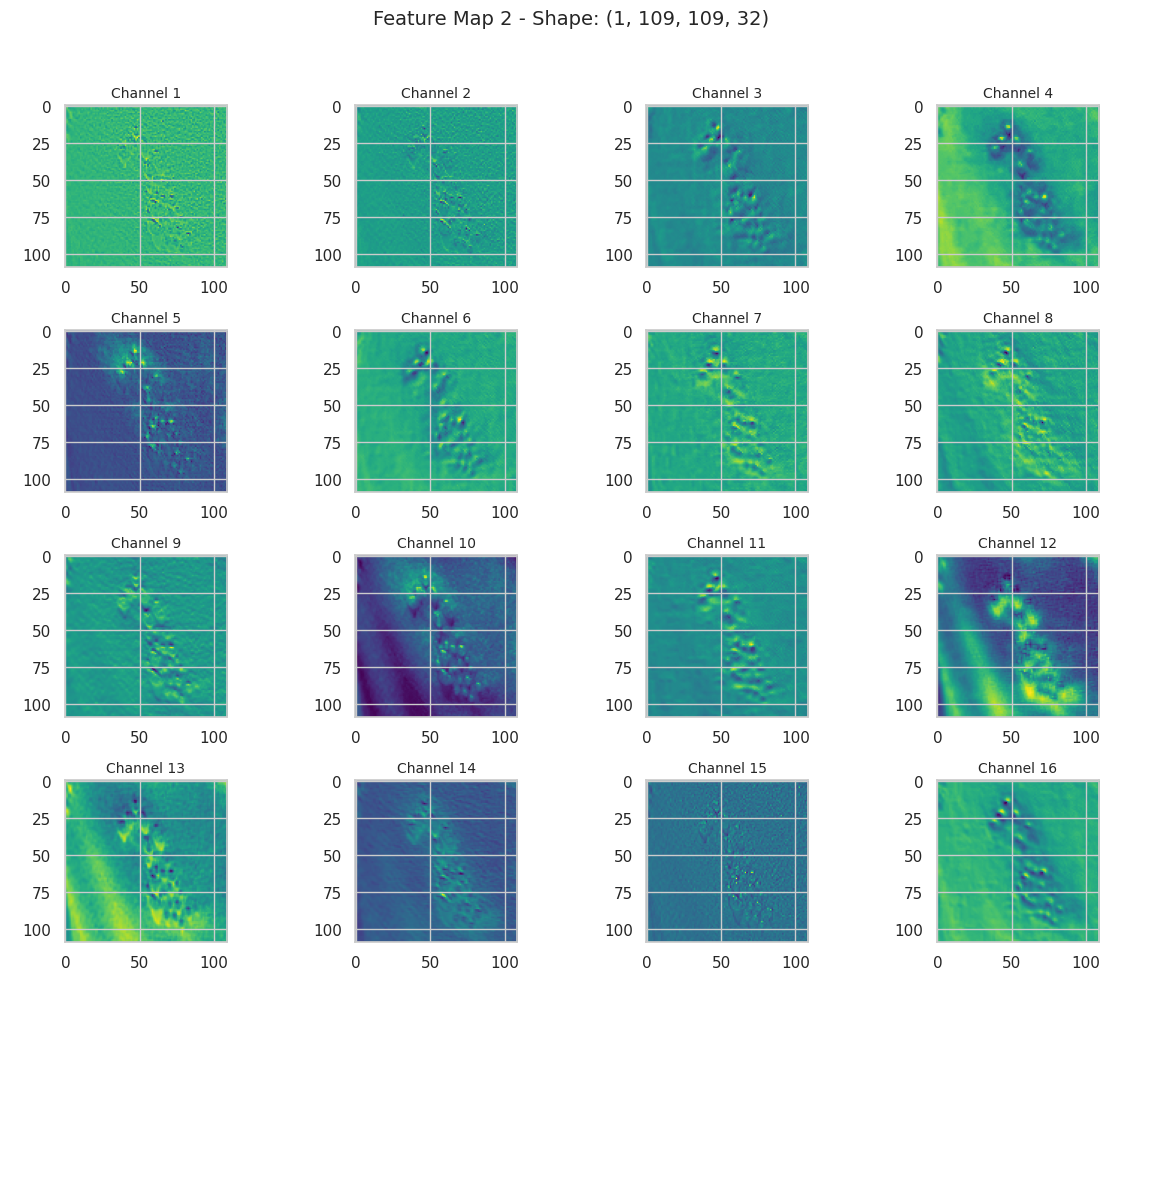

In [19]:
from tensorflow.keras.models import Model
import tensorflow as tf
import matplotlib.pyplot as plt

def plot_feature_maps(model, test_img_path, layers_to_visualize=5, max_feature_maps=16):
    # Load and preprocess the test image
    print("Loading and preprocessing the test image...")
    img = tf.keras.preprocessing.image.load_img(test_img_path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, axis=0)
    print(f"Image shape after preprocessing: {img_array.shape}")

    # Extract the base model from the sequential model
    base_model = model.layers[0]  # Assumes the first layer is the pre-trained base model
    print(f"Base model: {base_model.name}")

    # Get the total number of layers in the base model
    total_layers = len(base_model.layers)
    print(f"Total layers in the base model: {total_layers}")

    # Select the first and last 'n' layers
    print(f"Selecting the first {layers_to_visualize} layers and the last {layers_to_visualize} layers...")
    selected_layers = base_model.layers[:layers_to_visualize] + base_model.layers[-layers_to_visualize:]
    
    # Create a submodel for feature extraction from the selected layers
    print("Creating submodel for feature extraction...")
    feature_model = Model(
        inputs=base_model.input,
        outputs=[layer.output for layer in selected_layers if 'conv' in layer.name or 'pool' in layer.name]
    )
    print(f"Submodel created with {len(feature_model.layers)} layers for feature extraction.")

    # Generate feature maps
    print("Generating feature maps...")
    feature_maps = feature_model.predict(img_array)
    print(f"Generated {len(feature_maps)} feature maps from the selected layers.")

    # Plot the feature maps
    for idx, fmap in enumerate(feature_maps):
        num_channels = min(fmap.shape[-1], max_feature_maps)  # Limit to max_feature_maps number of channels
        size = fmap.shape[1]
        cols = 4  # Number of columns for the grid
        rows = (num_channels // cols) + 1  # Calculate number of rows based on the number of feature maps

        print(f"Plotting feature map {idx + 1} with shape: {fmap.shape}")

        fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
        fig.suptitle(f"Feature Map {idx + 1} - Shape: {fmap.shape}", fontsize=14)

        # Loop through the feature maps and plot them
        for i in range(rows * cols):
            if i < num_channels:
                ax = axes[i // cols, i % cols]
                ax.imshow(fmap[0, :, :, i], cmap='viridis')
                ax.set_title(f"Channel {i+1}", fontsize=10)
                ax.axis('on')  # Show axis for better reference
            else:
                axes[i // cols, i % cols].axis('off')  # Turn off axes for unused grid cells

        plt.tight_layout()
        plt.subplots_adjust(top=0.9)  # Adjust layout to make room for the suptitle
        plt.show()

# Provide a sample image path from your test dataset
sample_img_path = '/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set/VI-shingles/127_VI-shingles (32).jpg'

# Generate feature maps for each model
print("Generating feature maps for DenseNet121...")
plot_feature_maps(densenet_model, sample_img_path)

print("Generating feature maps for InceptionV3...")
plot_feature_maps(inception_model, sample_img_path)




**1. Input Layer:**  
The model begins with an input layer that accepts images of shape **(img_height, img_width, 3)** (3 channels for RGB).  

**2. Feature Extraction from Pre-trained Models:**  
**DenseNet and Inception Models:**  
- The pre-trained DenseNet and Inception models (**densenet_base** and **inception_base**) are used as feature extractors.  
- **training=False:** Ensures the base models are frozen during training (they do not update their weights).  
- Outputs are passed through **GlobalAveragePooling2D** layers to reduce their dimensions and obtain a compact feature representation.  

**3. Concatenation of Feature Maps:**  
Outputs from DenseNet and Inception are concatenated using **Concatenate()** to combine their feature representations into a single tensor.  

**4. Dense Layers for Classification:**  
- A dense layer (**Dense(1024, activation='relu')**) is added to introduce learnable parameters to process the concatenated features.  
- A dropout layer (**Dropout(0.5)**) is included to reduce overfitting by randomly dropping 50% of the neurons during training.  
- The final output layer (**Dense(num_classes, activation='softmax')**) provides probabilities for each class.  

**5. Model Compilation:**  
The model is compiled with:  
- **Optimizer:** Adam, for efficient gradient descent.  
- **Loss Function:** sparse_categorical_crossentropy, suitable for multi-class classification.  
- **Metrics:** Accuracy, to monitor the model's performance.  
```

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet121         │ (None, 7, 7,      │  7,037,504 │ input_layer_27[0… │
│ (Functional)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_v3        │ (None, 5, 5,      │ 21,802,784 │ input_layer_27[0… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1024)      │          0 │ densenet121[2][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ inception_v3[1][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 3072)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 1024)      │  3,146,752 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 1024)      │          0 │ dense_34[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 8)         │      8,200 │ dropout_17[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 31,995,240 (122.05 MB)

 Trainable params: 3,154,952 (12.04 MB)

 Non-trainable params: 28,840,288 (110.02 MB)

Epoch 1/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 83s 367ms/step - accuracy: 0.5847 - loss: 1.4555 - val_accuracy: 0.8712 - val_loss: 0.3707
Epoch 2/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.8777 - loss: 0.3391 - val_accuracy: 0.9056 - val_loss: 0.2482
Epoch 3/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 0.9252 - loss: 0.2120 - val_accuracy: 0.8970 - val_loss: 0.3652
Epoch 4/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - accuracy: 0.9540 - loss: 0.1339 - val_accuracy: 0.9056 - val_loss: 0.2759
Epoch 5/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.9593 - loss: 0.1204 - val_accuracy: 0.9270 - val_loss: 0.2294
Epoch 6/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.9648 - loss: 0.0999 - val_accuracy: 0.9142 - val_loss: 0.3112
Epoch 7/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.9715 - loss: 0.0794 - val_accuracy: 0.9442 - val_loss: 0.2168
Epoch 8/80
145/145 ━━━━━━━━━━━━━━━━━━━━ 21s 145ms/step - accuracy: 0.9761 - loss: 0

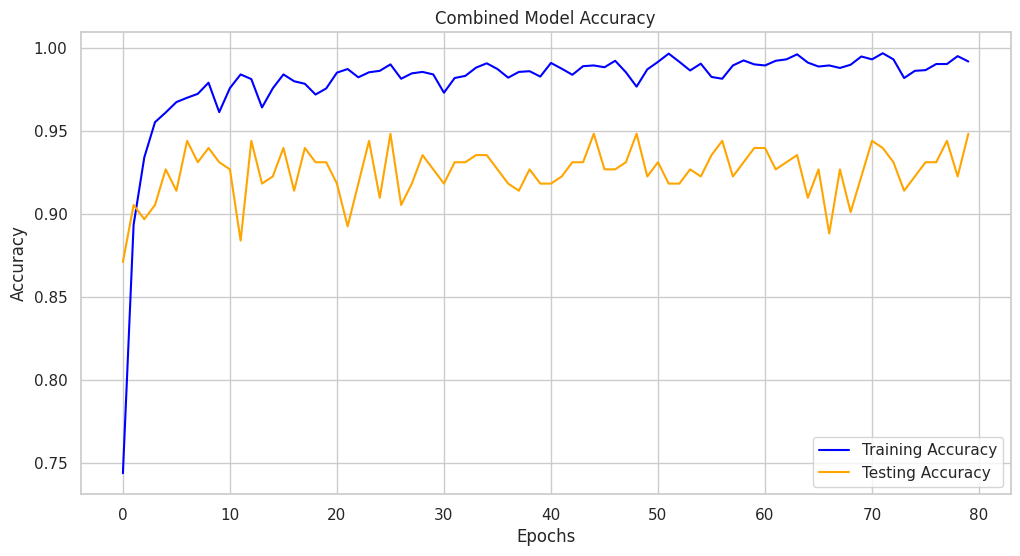

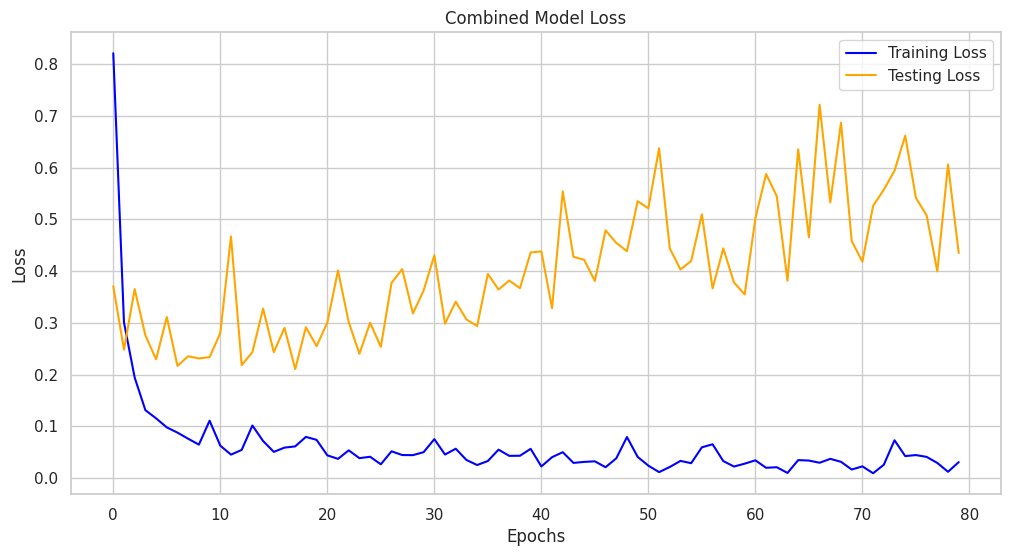

Final Training Accuracy for Combined Model: 0.9920
Final Testing Accuracy for Combined Model: 0.9485



In [24]:
from tensorflow.keras.layers import Concatenate, Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

# Define the input layer
input_layer = Input(shape=(img_height, img_width, 3))

# Extract outputs from DenseNet and Inception models
densenet_output = densenet_base(input_layer, training=False)
densenet_output = GlobalAveragePooling2D()(densenet_output)

inception_output = inception_base(input_layer, training=False)
inception_output = GlobalAveragePooling2D()(inception_output)

# Concatenate outputs from DenseNet and Inception models
combined_output = Concatenate()([densenet_output, inception_output])

# Add dense layers on top of the combined output
x = Dense(1024, activation='relu')(combined_output)
x = Dropout(0.5)(x)
final_output = Dense(num_classes, activation='softmax')(x)

# Create the combined model
combined_model = Model(inputs=input_layer, outputs=final_output)

# Compile the combined model
combined_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
combined_model.summary()

# Visualize the combined model architecture
plot_model(combined_model, to_file='combined_model_architecture.png', show_shapes=True, show_layer_names=True)

# Train the combined model
combined_history = combined_model.fit(train_generator, epochs=80, validation_data=test_generator)

# Plot learning curves for the combined model
def plot_learning_curves(history, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Testing Accuracy', color='orange')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Testing Loss', color='orange')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot the learning curves for the combined model
plot_learning_curves(combined_history, 'Combined Model')

# Print final accuracy of the combined model
def print_final_accuracies(history, model_name):
    print(f"Final Training Accuracy for {model_name}: {history.history['accuracy'][-1]:.4f}")
    print(f"Final Testing Accuracy for {model_name}: {history.history['val_accuracy'][-1]:.4f}\n")

# Print the final accuracy of the combined model
print_final_accuracies(combined_history, 'Combined Model')


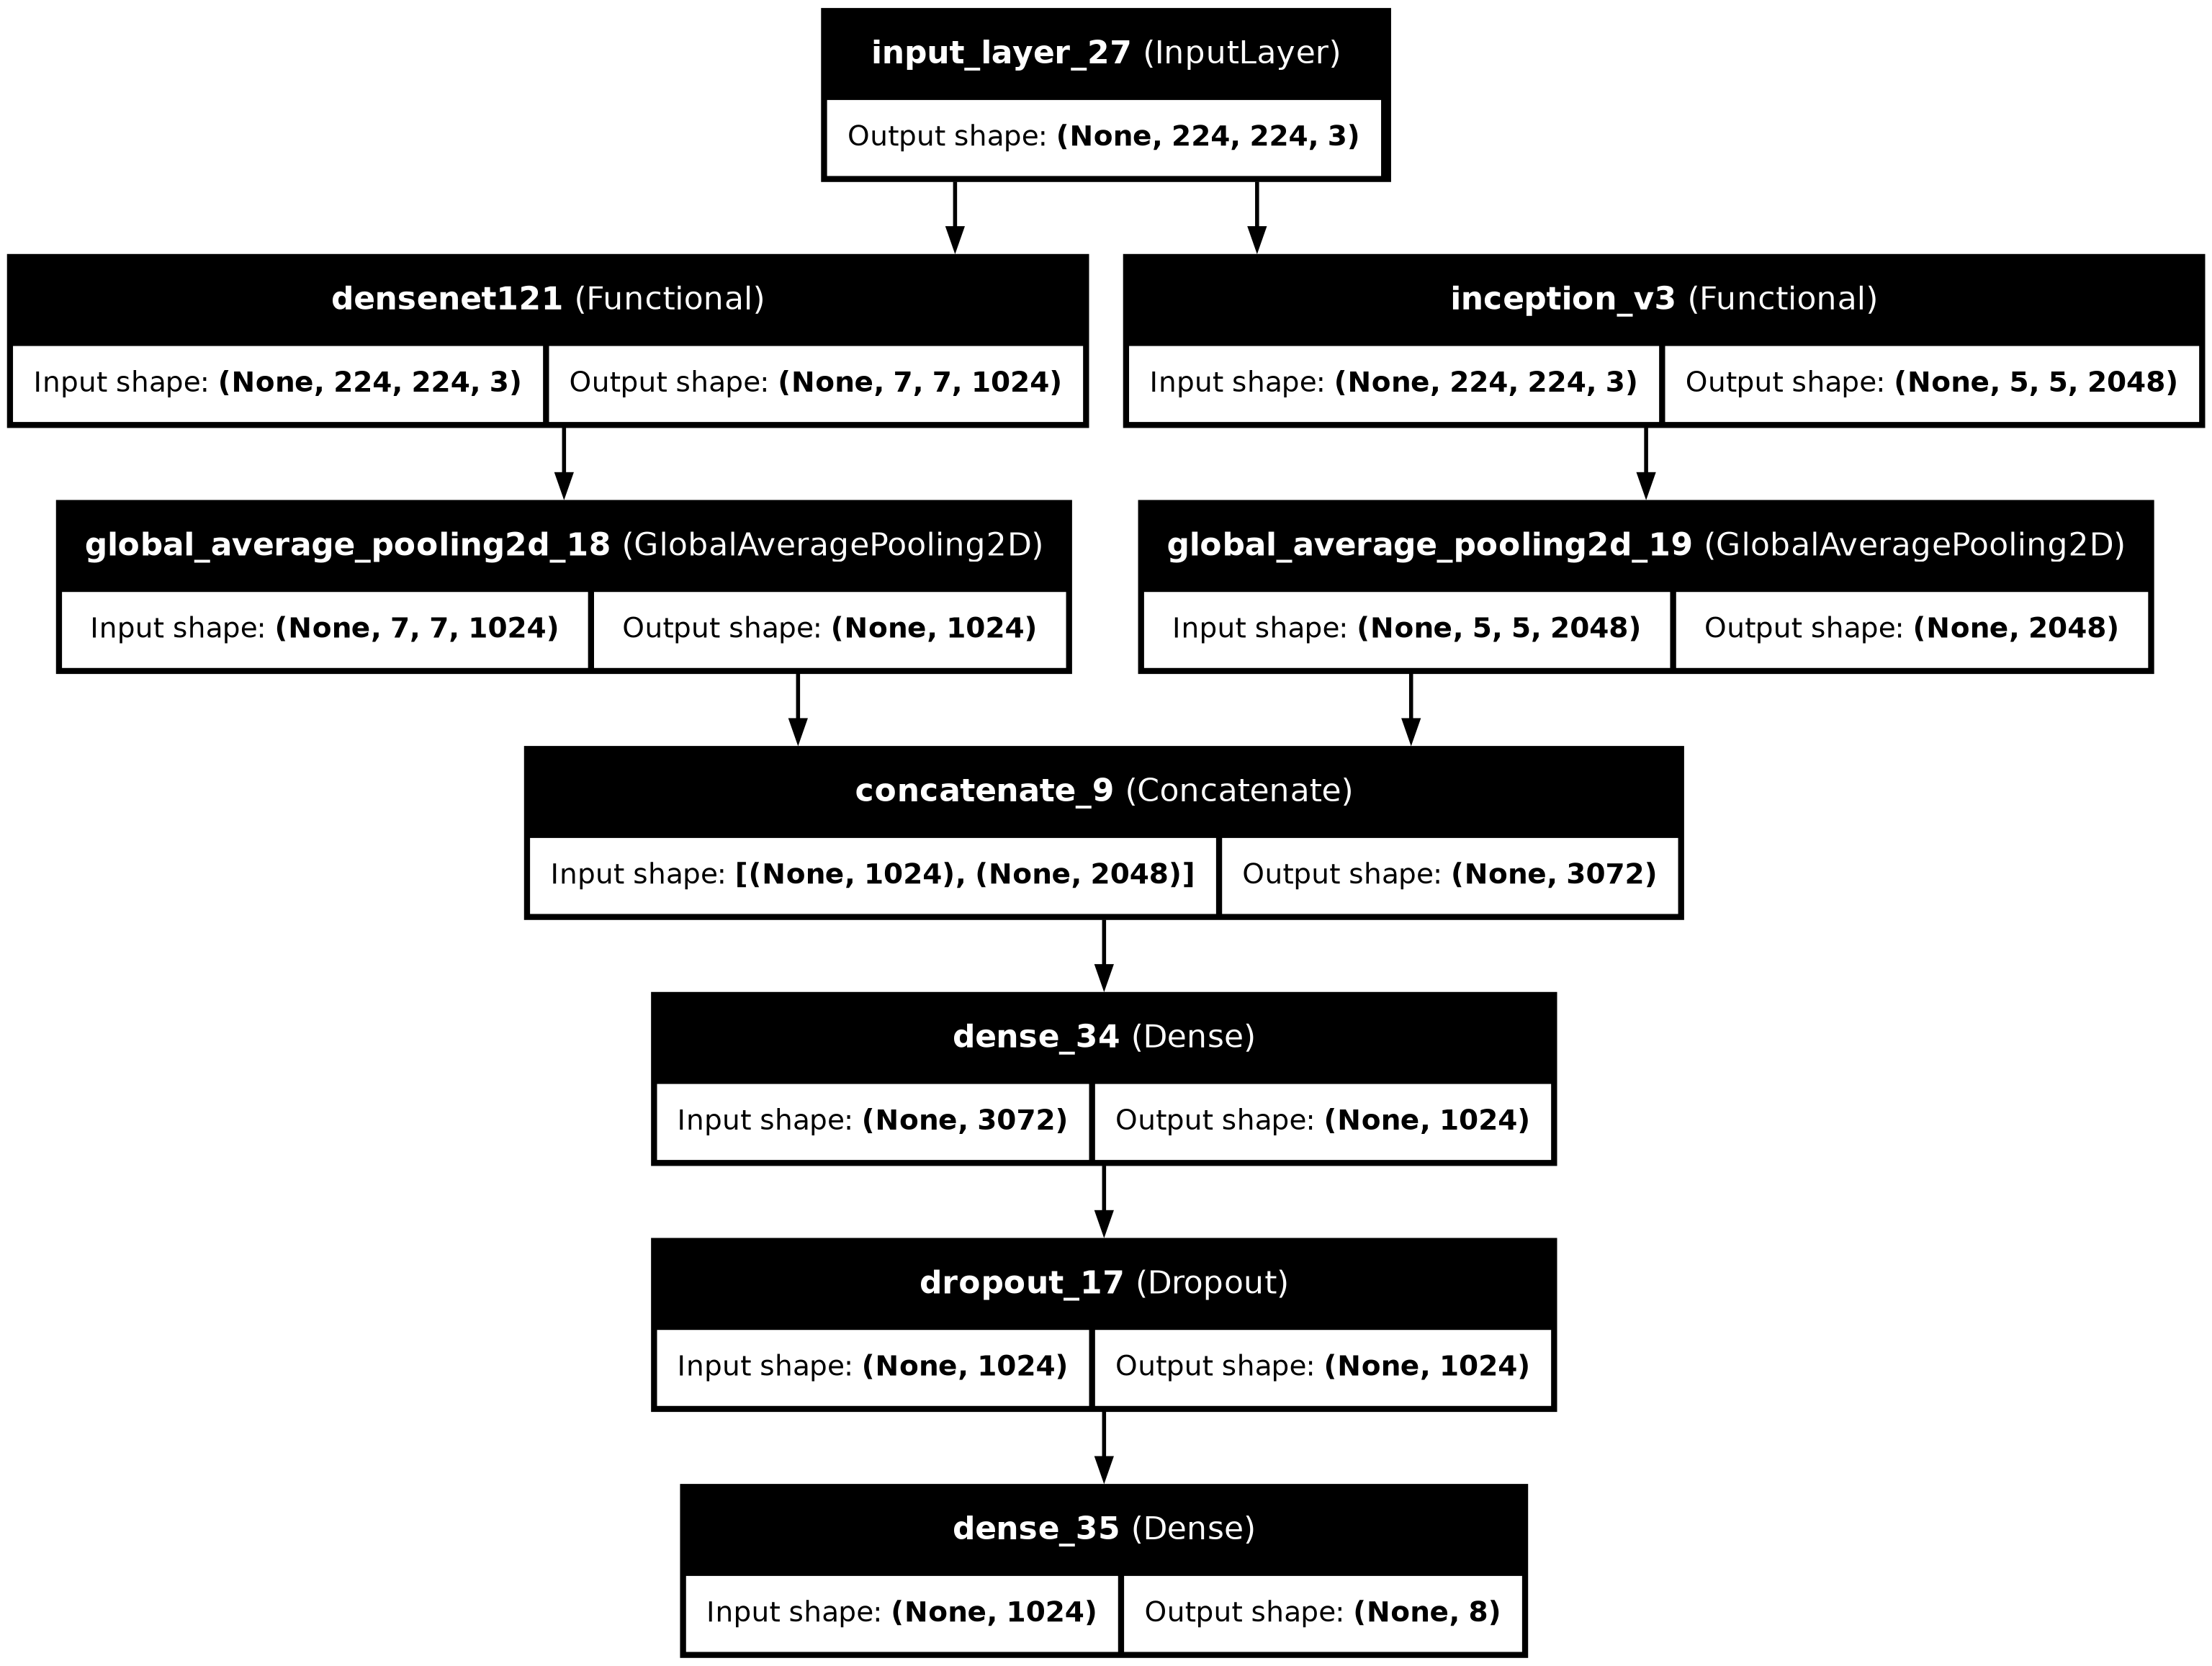

In [26]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Plot the model architecture
plot_model(combined_model, to_file='combined_model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the image
Image('combined_model_architecture.png')


8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step 


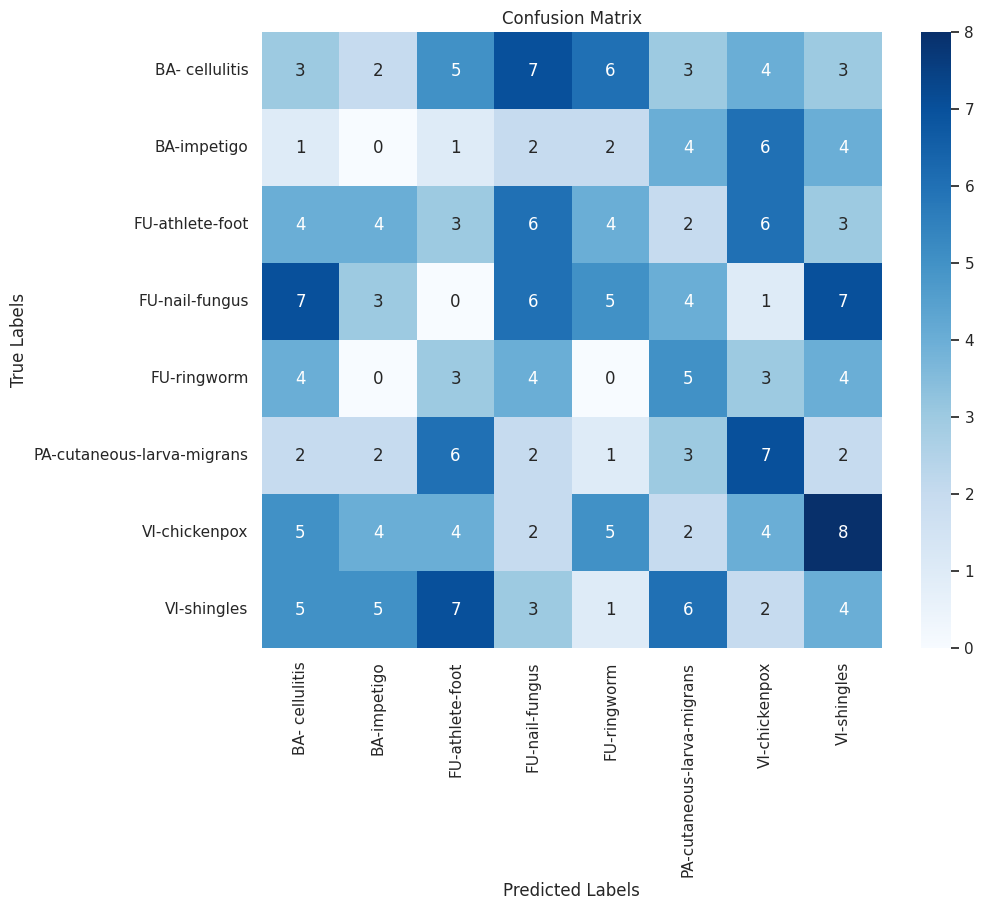

In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model

# Function to plot confusion matrix
def plot_confusion_matrix(model, test_generator, num_classes):
    # Get the true labels and predicted labels
    true_labels = test_generator.classes
    predicted_probs = model.predict(test_generator, verbose=1)
    predicted_labels = np.argmax(predicted_probs, axis=1)
    
    # Generate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Plot confusion matrix for the combined model
plot_confusion_matrix(combined_model, test_generator, num_classes)
